# Creative Machine Learning - Diffusion models

#### Author : Philippe Esling (esling@ircam.fr)

In this notebook we will implement :
   1. Denoising Score matching.
   2. Sampling with Langevin dynamics.
   3. A simple implemenation of the [EDM](https://arxiv.org/pdf/2206.00364) formulation.


## Theoretical bases - quick recap

In this section we provide a quick recap on **score matching** based on the _swiss roll_ dataset.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

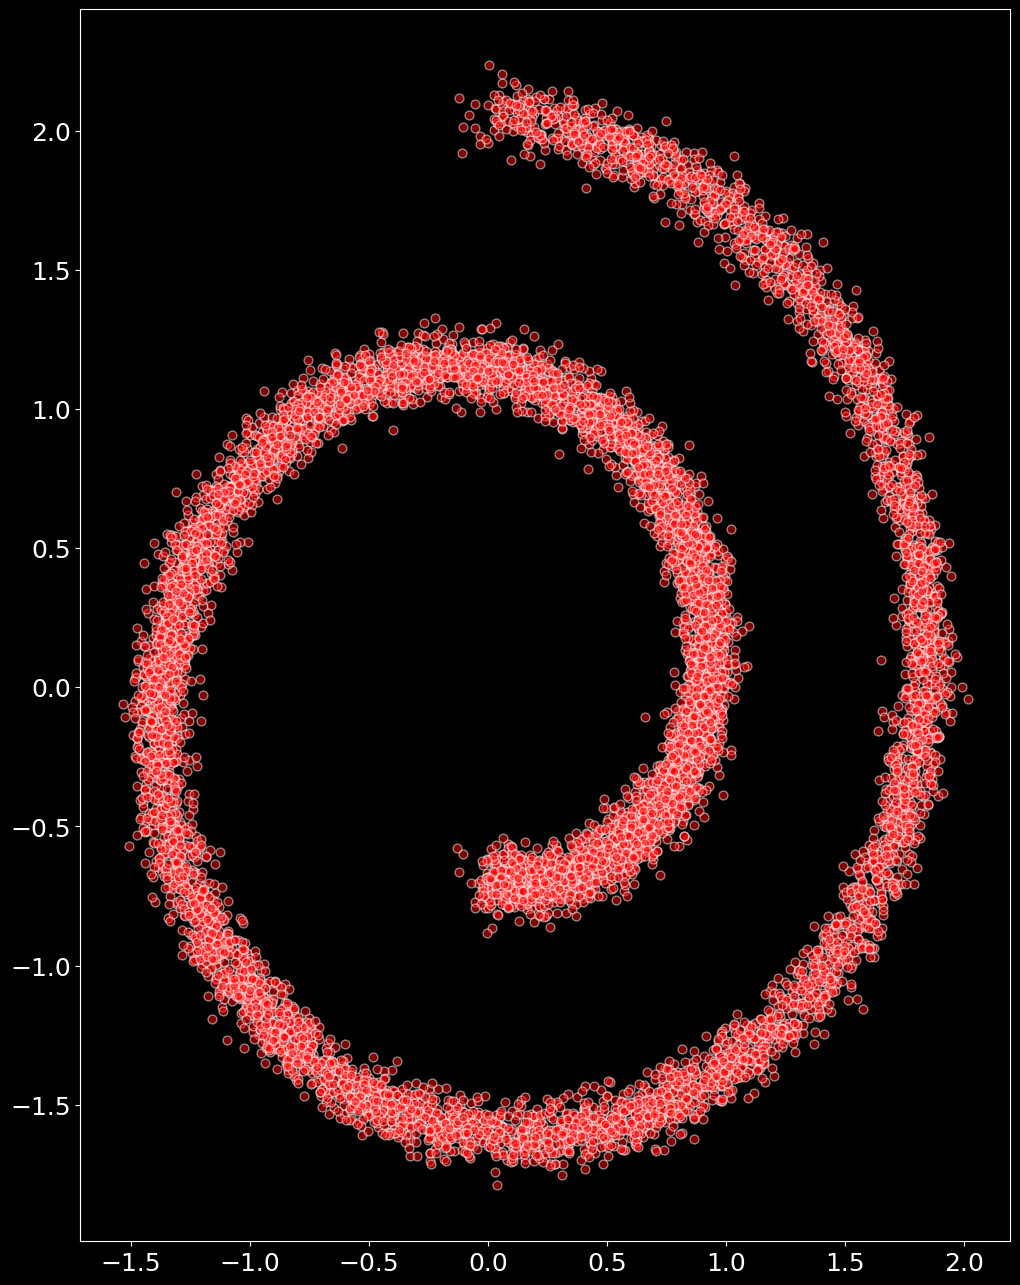

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
from cml.plot import cml_figure_matplotlib as figure
# Sample a batch from the swiss roll
def sample_batch(size, noise=0.4):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 5.0
# Plot it
data = sample_batch(10**4).T
data = data/data.std()
figure(16, 12)
plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=40)

### Score matching

_Score matching_ aims to learn the _gradients_ (termed _score_) of $\log p(\mathbf{x})$ with respect to $\mathbf{x}$ instead of directly $\log p(\mathbf{x})$. Therefore, we seek a model to approximate
$$
\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})
$$

We have seen that optimizing this model with an MSE objective was equivalent to optimizing

$$ \mathcal{L}_{matching} = E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right) + \frac{1}{2} \left\Vert \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2 \right]
, $$

where $\nabla_{\mathbf{x}} \mathcal{F}_{\theta}(\mathbf{x})$ denotes the Jacobian of $\mathcal{F}_{\theta}(\mathbf{x})$ with respect to $\mathbf{x}$. The problem with this formulation lies in the computation of this Jacobian, which does not scale well to high-dimensional data.

#### Denoising score matching

Originally, _denoising score matching_ was discussed by Vincent [ [ 3 ] ](#ref3) in the context of _denoising auto-encoders_. In our case, we can completely remove the use of $\nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})$ in the computation of score matching, by corrupting the inputs through a distribution $q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})$. It has been shown that the optimal network $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})$ can be found by minimizing the following objective

$$ E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}) - \nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) \right\lVert_2^2 \right]
, $$

An important remark is that $\mathcal{F}_{\theta}(\mathbf{x}) = \nabla_{\mathbf{x}} \log q_{\sigma}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \log p(\mathbf{x})$ is only true when the noise is small enough $q_{\sigma}(\mathbf{x}) \approx p(\mathbf{x})$. As it has been shown in [ [ 3 ] ](#ref3),[ [ 8 ] ](#ref8), if we choose the noise distribution to be $q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})=\mathcal{N}(\tilde{\mathbf{x}}\mid\mathbf{x}, \sigma^{2}\mathbf{I})$, then we have $\nabla_{\tilde{\mathbf{x}}} \log q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x}) = \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}}$. Therefore, the denoising score matching loss simply becomes

$$ \mathcal{l}(\theta;\sigma) = E_{q_{\sigma}(\tilde{\mathbf{x}}\mid\mathbf{x})} E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\Vert \mathcal{F}_{\theta}(\tilde{\mathbf{x}}) +  \frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^{2}} \right\lVert_2^2 \right]
, $$

We can implement the _denoising score matching_ loss as follows

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.1 - Implementing denoising score matching

> 1. Fill the `denoising_score_matching` function 
> 2. Test your implementation with the following training cell
    
</div>

***

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

def denoising_score_matching(scorenet, samples, sigma=0.01):
    
    ######################
    # YOUR CODE GOES HERE
    ######################
    noise = torch.randn_like(samples) * sigma
    samples_tilde = samples + noise
    F_theta = scorenet(samples_tilde)
    loss = (F_theta + noise / (sigma**2)).norm(dim=1)
    loss = loss ** 2

    return loss.mean()

Regarding optimization, we can perform a very simple implementation of this process, by define $\mathcal{F}_{\theta}(\mathbf{x})$ as being any type of neural network. We can perform the minimalistic implementation as follows

In [3]:
# Our approximation model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
for t in range(5000):
    # Compute the loss.
    loss = denoising_score_matching(model, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    # Print loss
    if ((t % 1000) == 0):
        print(loss)

tensor(19821.8750, grad_fn=<MeanBackward0>)
tensor(20079.3047, grad_fn=<MeanBackward0>)
tensor(19860.1621, grad_fn=<MeanBackward0>)
tensor(19743.7656, grad_fn=<MeanBackward0>)
tensor(20083.8203, grad_fn=<MeanBackward0>)


We can observe that our model has learned to represent $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_x \log p(x)$ by plotting the output value across the input space

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

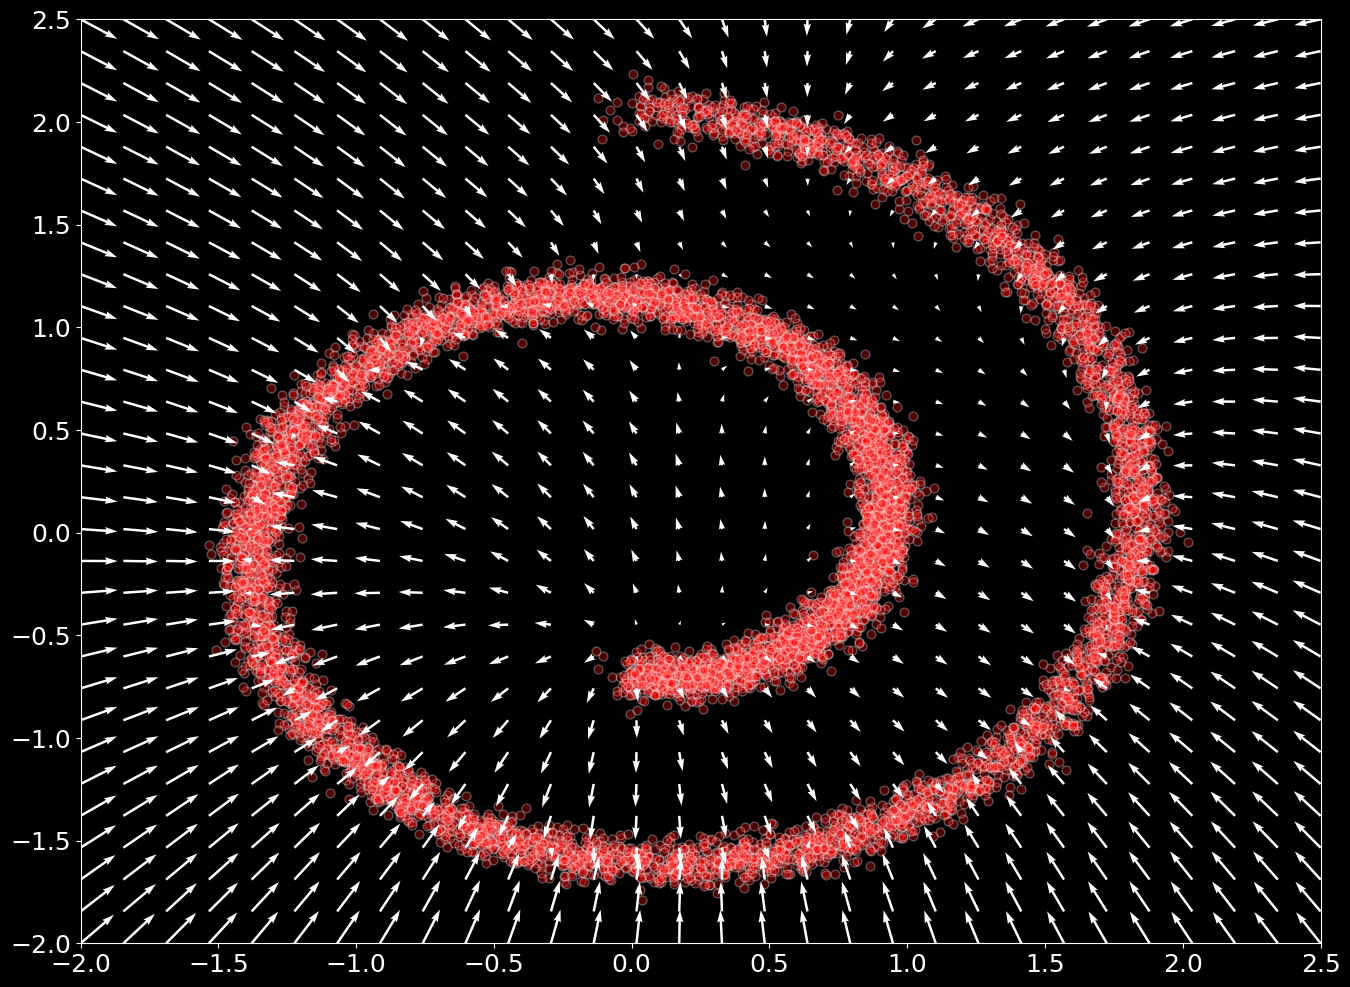

In [4]:
def plot_gradients(model, data, plot_scatter=True):
    xx = np.stack(np.meshgrid(np.linspace(-2, 2.5, 30), np.linspace(-2, 2.5, 30)), axis=-1).reshape(-1, 2)
    scores = model(torch.from_numpy(xx).float()).detach()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    # Perform the plots
    plt.figure(figsize=(16,12))
    if (plot_scatter):
        plt.scatter(*data, alpha=0.3, color='red', edgecolor='white', s=40)
    plt.quiver(xx.T[0], xx.T[1], scores_log1p[:,0], scores_log1p[:,1], width=0.002, color='white')
    plt.xlim(-2, 2.5)
    plt.ylim(-2, 2.5)
    
plot_gradients(model, data)
plt.savefig("grad.png")

### Langevin sampling

We have also seen that _Langevin dynamics_ is a process from thermodynamics that can produce true samples from a density $p(\mathbf{x})$, by relying only on $\nabla_{\mathbf{x}} \log p(\mathbf{x})$

$$\mathbf{x}_{t + 1} = \mathbf{x}_t + \frac{\epsilon}{2} \nabla_{\mathbf{x}_t} log p(\mathbf{x}_t) + \sqrt{\epsilon} \mathbf{z}_{t}$$

where $\mathbf{z}_{t}\sim \mathcal{N}(\mathbf{0},\mathbf{I})$ and under $\epsilon \rightarrow 0, t \rightarrow \inf$: $\mathbf{x}_t$ converges to an exact sample from $p(\mathbf{x})$. This is a key idea behind the _score-based generative modeling_ approach.


***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.2 - Implementing Langevin sampling

> 1. Fill the `sample_langevin` function 
> 2. Test your implementation with the provided code
    
</div>

***


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

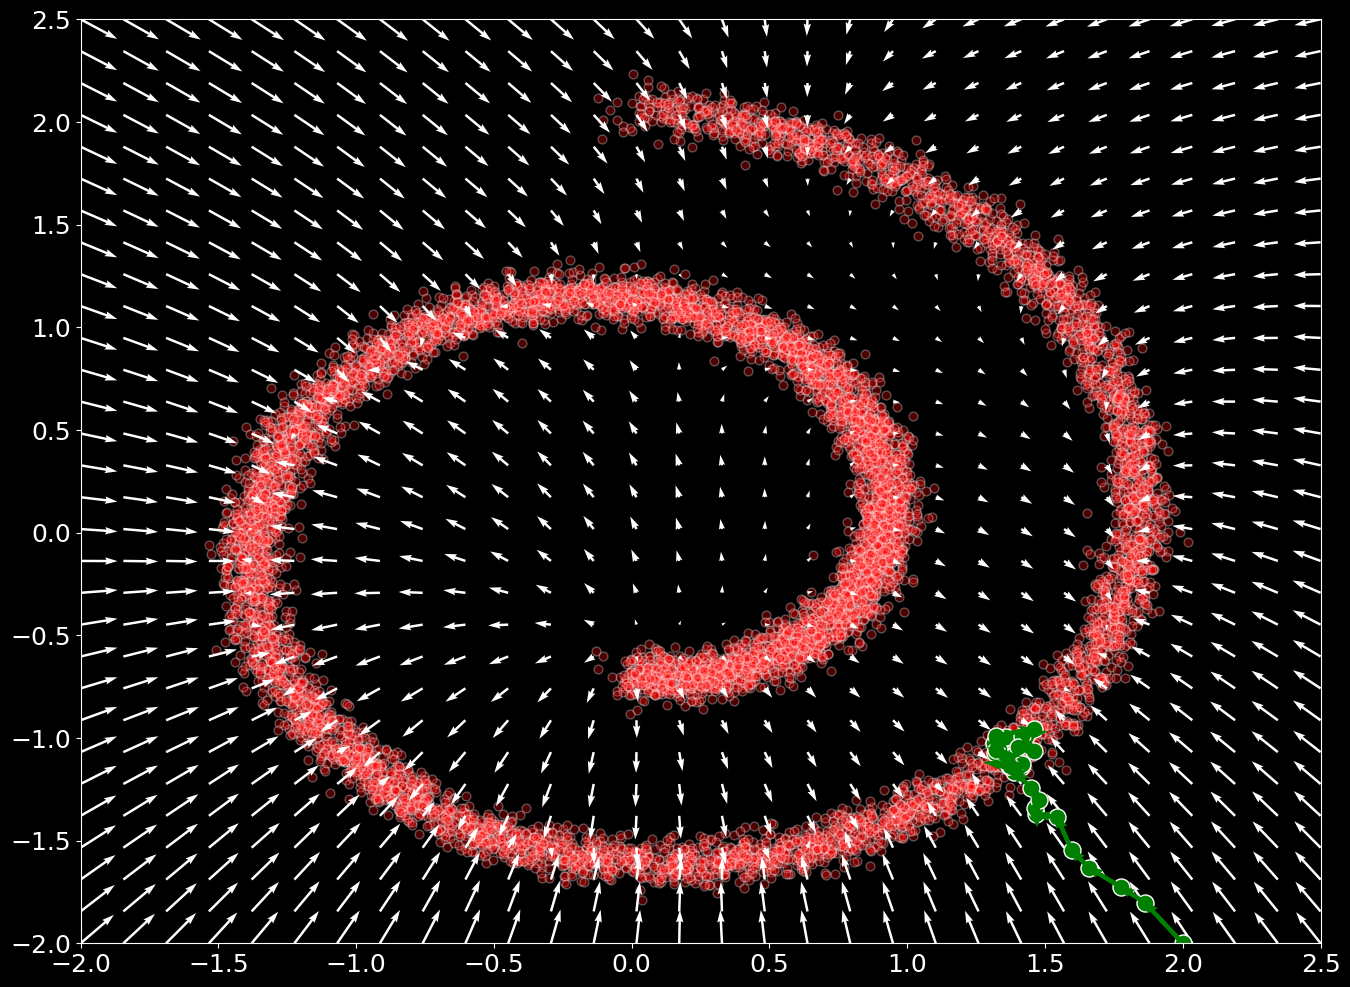

In [5]:
def sample_langevin(model, x, n_steps=30, eps=2e-3, decay=.99):
    
    
    x_sequence = [x]
    
    for _ in range(n_steps):
        
        ######################
        # YOUR CODE GOES HERE
        ######################
        z = torch.randn_like(x)
        x = x + eps/2 * model(x) + np.sqrt(eps) * z
        eps = eps * decay
        
        x_sequence.append(x)

    return torch.stack(x_sequence)

x = torch.Tensor([2, -2])
samples = sample_langevin(model, x).detach()
plot_gradients(model, data)
plt.scatter(samples[:, 0], samples[:, 1], color='green', edgecolor='white', s=150)
# draw arrows for each mcmc step
deltas = (samples[1:] - samples[:-1])
deltas = deltas - deltas / torch.tensor(np.linalg.norm(deltas, keepdims=True, axis=-1)) * 0.04
for i, arrow in enumerate(deltas):
    plt.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="green", linewidth=3)

## Diffusion models

_Diffusion probabilistic models_ were originally proposed by Sohl-Dickstein et al. [ [ 1 ] ](#ref1) based on non-equilibrium thermodynamics. These models are based on two reciprocal processes that represent two Markov chains of random variables. One process $q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})$ that gradually adds noise to the input data (called the _diffusion_ or _forward_ process), destroying the signal up to full noise. In the opposite direction, the _reverse_ process $p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})$ tries to learn how to invert this diffusion process (transform random noise into a high-quality waveform).

As we can see, the _forward_ (and fixed) process $q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})$ gradually introduces noise at each step. Oppositely, the _reverse_ (parametric) process $p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})$ must learn how to _denoise local perturbations_. Hence, learning involves estimating a _large number of small perturbations_, which is more tractable than trying to directly estimate the full distribution with a single potential function. 

Both processes can be defined as parametrized Markov chains, but the _diffusion_ process is usually simplified to inject pre-selected amounts of noise at each step. The _reverse_ process is trained using variational inference, and can be modeled as conditional Gaussians, which allow for neural network parameterization and tractable estimation.

### The EDM formulation

In this notebook, we will focus on implementing the formulation introduced in Elucidating the Design space of Diffusion models (EDM) introduced by Karras et al. [ [ 9 ] ](#ref9). 

Following the connection between stochastic differential equations and the diffusion process, Karras et al. [ [ 9 ] ](#ref9) propose a simple diffusion process where we consider the intermediate distributions to be a familly of mollified distributions $p(\mathbf{x}; \sigma)$ obtained by adding i.i.d Gaussian noise of standard deviation $\sigma$ to the data. Considering a noise schedule $\sigma(t)$ increasing between $\sigma(0) = 0$ and $\sigma(N) = \sigma_{max}$, we can generate samples at each noise levels $x_t \sim p(x_t, \sigma(t))$ from a sample $x_0$ as $$x(t) = x(0) + \sigma(t) \epsilon$$ where $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

Considering this definition, the authors demonstrate that the evolution of a sample $x_a \sim p(x_a, \sigma(t_a))$ from time $t_a$ to $t_b$, yielding a sample $x_b \sim p(x_b, \sigma(t_b))$ is govern by the following ODE : $$\mathrm{d} \boldsymbol{x}=-\dot{\sigma}(t) \sigma(t) \nabla_{\boldsymbol{x}} \log p(\boldsymbol{x} ; \sigma(t)) \mathrm{d} t$$

Considering we know a good estimate of the score function at different noise levels, we can generate samples by sampling the prior $x_N \sim \mathcal{N}(\mathbf{0}, \sigma_{max}^2\mathbf{I})$ and successively discretize the ODE until $t=0$.

#### Training

We need to train a neural network to approximate the score function at the different noise levels. Following ideas from Denoising Score Matching, if a denoiser function $D_{\theta}(x; \sigma)$ minimize for each $\sigma$ separately 
$$\mathbb{E}_{\boldsymbol{x} \sim p_{\text {data }}} \mathbb{E}_{\boldsymbol{\epsilon} \sim \mathcal{N}\left(\mathbf{0}, \sigma^2 \mathbf{I}\right)}\|D_\theta(\boldsymbol{x}+\boldsymbol{\epsilon} ; \sigma)-\boldsymbol{x}\|_2^2$$

then :

$$\nabla_{\boldsymbol{x}} \log p(\boldsymbol{x} ; \sigma)=(D_\theta(\boldsymbol{x} ; \sigma)-\boldsymbol{x}) / \sigma^2$$



We need to train the denoiser at all the level of noise between 0 and $\sigma_{max}$. At very high noise levels, it is impossible for the denoiser to find the training target (and hence the network approximates the mean of the dataset) while at very low noise levels, it is difficult and pointless to identify the vanishing noise component in the data. Hence, Karras et al. [ [ 9 ] ](#ref9) proposed to focus the training effort on the intermediate noise levels by sampling the noise levels from a simple log-normal distribution : $$ln(\sigma) \sim \mathcal{N}(P_{mean}, P^2_{std}).$$

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found bec

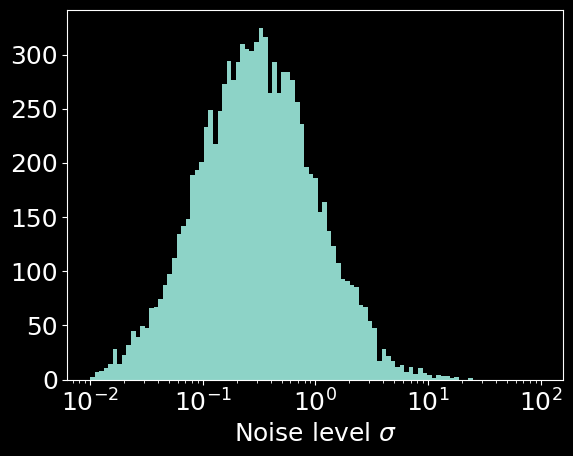

In [6]:
def sample_lognormal(n_samples, p_mean = -1.2, p_std = 1.2):
    z = torch.randn(n_samples)
    sigma = (z * p_std + p_mean).exp()
    return sigma


sigmas = sample_lognormal(10000)

plt.xscale('log')
bins = 10**(np.linspace(-2,2, 100))
plt.hist(sigmas, bins=bins)
plt.xlabel("Noise level $\sigma$")
plt.show()

### Training loss


***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question　2.2 - Training loss implementation

> 1. Fill the `compute_loss` function based on the EDM denoising objective
    
</div>

***


In [ ]:
def EDM_loss(batch, model, p_std = 1.2, p_mean = -1.2):
    
    # Sample noise levels follwing a log-normal distribution
    noise_levels = sample_lognormal(batch.size(0), p_mean, p_std).view(-1, 1)
    
    # Noise each sample in the dataset with the corresponding noise level
    noised_samples = batch + noise_levels * torch.randn_like(batch)
    
    # Compute the denoising loss
    loss = ((model(noised_samples, noise_levels) - batch) ** 2).norm(dim=1)

    return loss.mean()

### Sampling loop

In the EDM formulation, samples are generated by successive application of the Euler discretisation of the following ODE $$\mathrm{d} \boldsymbol{x}=-\dot{\sigma}(t) \sigma(t) \nabla_{\boldsymbol{x}} \log p(\boldsymbol{x} ; \sigma(t)) \mathrm{d} t,$$ which gives the scheme $$x_{t_{i-1}} = x_{t_i} + \dot{\sigma_t} \frac{x_{t_i} - D_\theta(x_{t_i}, \sigma_t)}{\sigma_{t_i}} \Delta_t$$ where $\Delta_t = t_{i-1} - t_{i}$.

In this simple example we will consider $\sigma(t) = t$.

We still need to define the time steps $t_i$ at which we approximate the differential equation, between $\sigma_0 = 0$ and $\sigma_N = \sigma_{max}$. Karras et al. [ [ 9 ] ](#ref9) showed experimentally that the discretization step should decrease with the noise level and proposed the following scheme : $$\sigma_{0<i<=N} = (\sigma_{min}^{1/\rho} + \frac{i}{N-1}(\sigma_{max}^{1/\rho} - \sigma_{min}^{1/\rho}))^\rho$$ 
and $\sigma_0 = 0$. The parameter $\rho$ controls the trade off between the number of steps at low noise levels and the number of steps at high noise levels.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

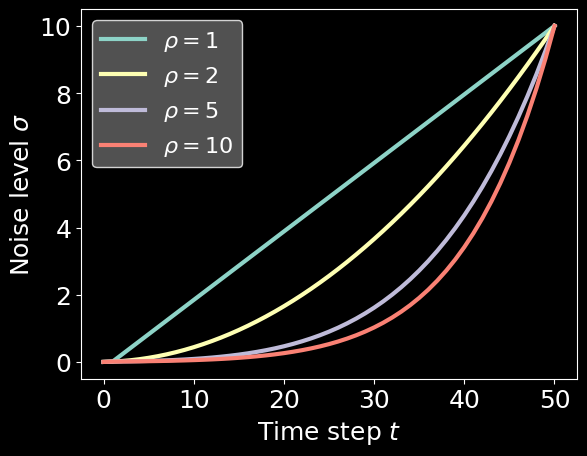

In [15]:
def get_steps(n_steps, rho, sigma_min, sigma_max):
    step_indices = torch.arange(0, n_steps)
    t_steps = (sigma_min**(1 / rho) + step_indices / (n_steps - 1) * (sigma_max**(1 / rho) - sigma_min**(1 / rho)))**rho
    t_steps = torch.cat([torch.tensor([0.]), t_steps])      
    t_steps = torch.as_tensor(t_steps)
    
    return t_steps

n_steps = 50
sigma_min = 0.01
sigma_max = 10.

for rho in [1, 2, 5, 10]:
    t_steps = get_steps(n_steps, rho, sigma_min, sigma_max)
    plt.ylabel("Noise level $\sigma$")
    plt.xlabel("Time step $t$")
    plt.plot(t_steps, label=f'$\\rho={rho}$')
    plt.legend()

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question　2.3 - Sampling loop implementation

> 1. Fill the `sample_edm` function based on the EDM sampling scheme
    
</div>

***

In [23]:
def EDM_sampling(model, n_steps, n_samples, sigma_max = 5., sigma_min = 0.001, rho = 7.):
        
        out_samples = []
        
        # Sample initial noise
        x = torch.randn(n_samples, 2) * sigma_max

        # get the noise levels   
        noise_levels = get_steps(n_steps, rho, sigma_min, sigma_max)
        
        # Perform the sampling
        for i in range(n_steps-1):
                # reverse
                sigma_ti = noise_levels[n_steps - 1 - i]
                sigma_ti_1 = noise_levels[n_steps - 2 - i]
                delta_t = sigma_ti_1 - sigma_ti
                model_out = model(x, sigma_ti.repeat(n_samples, 1))
                x = x + (x - model_out) / sigma_ti * delta_t
                
                out_samples.append(x)
        return out_samples

In [24]:
import torch.nn.functional as F

class DenoisingMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, time_embedding_dim):
        super(DenoisingMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim+time_embedding_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim+time_embedding_dim, input_dim)
        
        self.time_embedding = nn.Linear(1, time_embedding_dim)
    
    def forward(self, x, sigma):
        x_res = x.clone()
        
        time_embedding = F.silu(self.time_embedding(sigma))
        
        x = F.silu(self.fc1(x))
        
        x = torch.cat([x, time_embedding], dim=-1)  
        x = F.silu(self.fc2(x))
        
        x = torch.cat([x, time_embedding], dim=-1)  
        x = self.fc3(x)
        
        return x

Loss: 0.3284555971622467:   0%|          | 0/5001 [00:01<?, ?it/s]findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none o

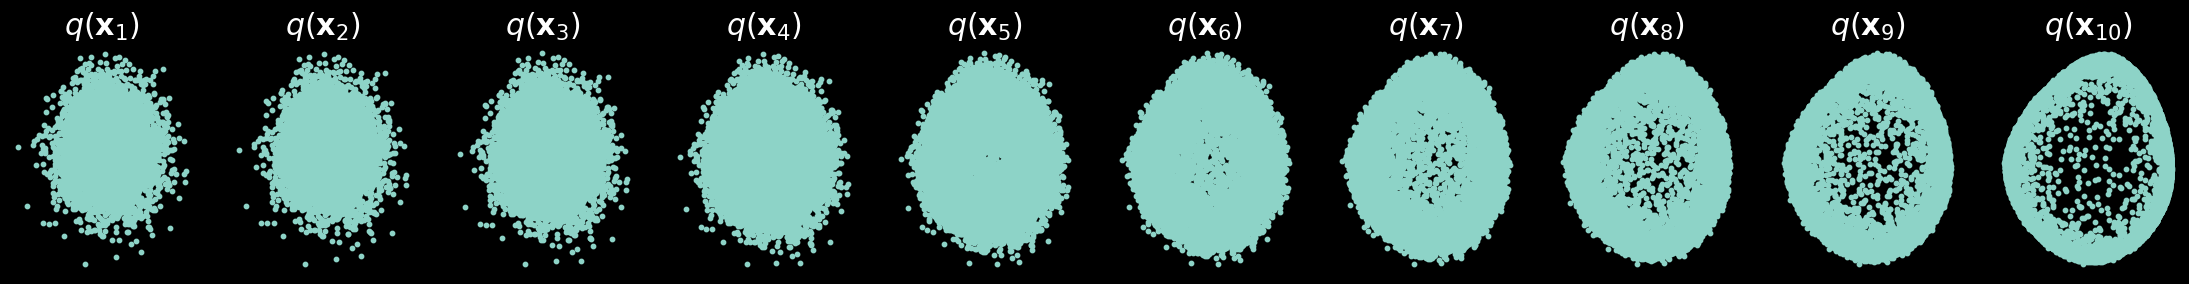

Loss: 0.26687633991241455:   2%|▏         | 114/5001 [02:03<1:28:37,  1.09s/it]findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found b

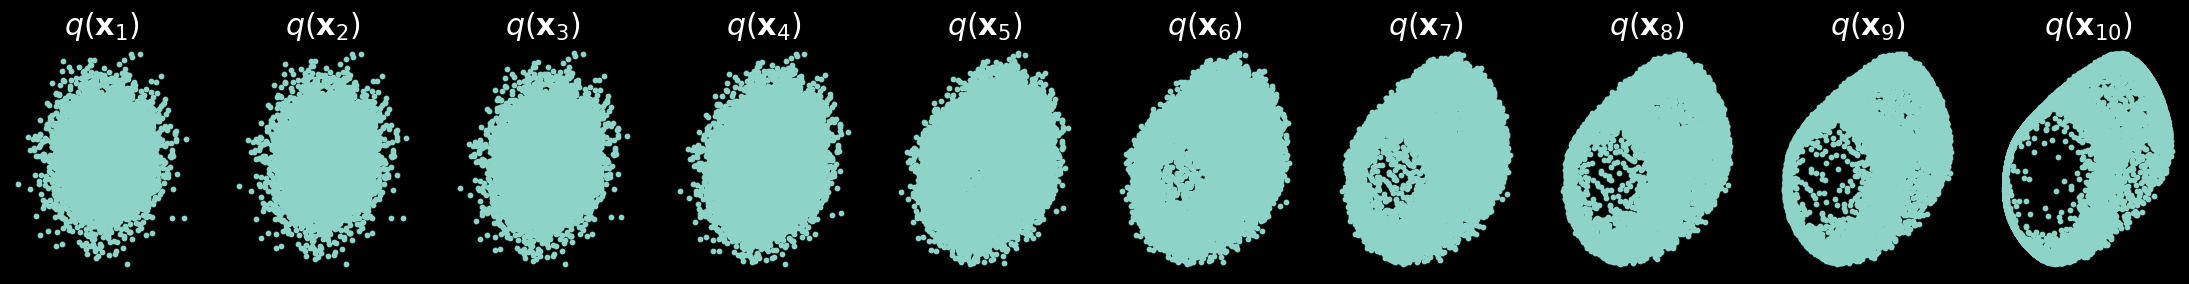

Loss: 0.13380128145217896:   4%|▍         | 220/5001 [04:04<1:19:19,  1.00it/s]findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found b

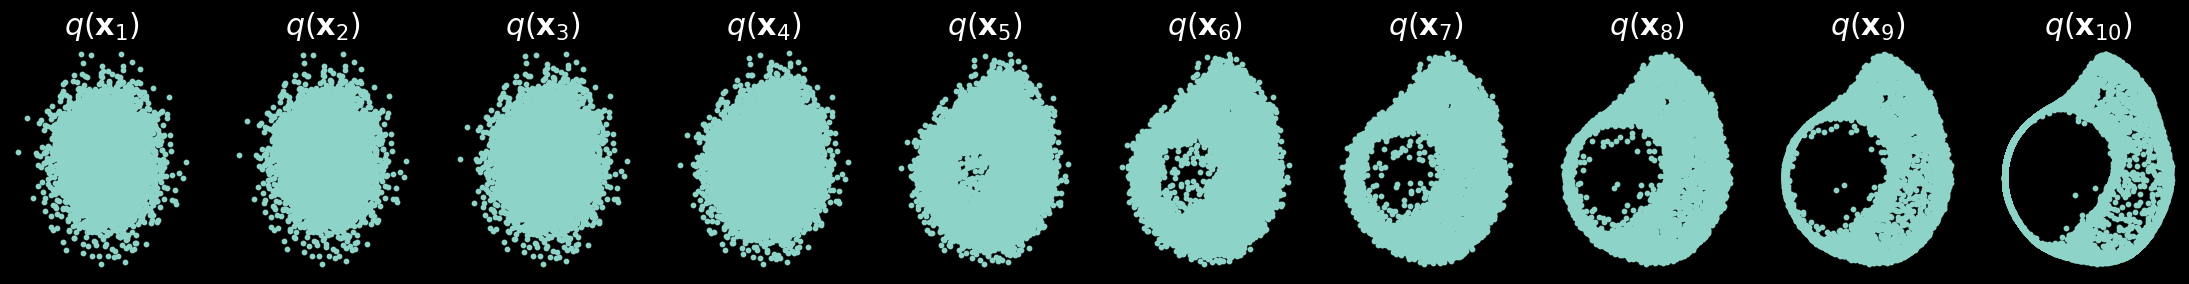

Loss: 0.31937193870544434:   6%|▋         | 324/5001 [05:58<1:03:01,  1.24it/s]findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found b

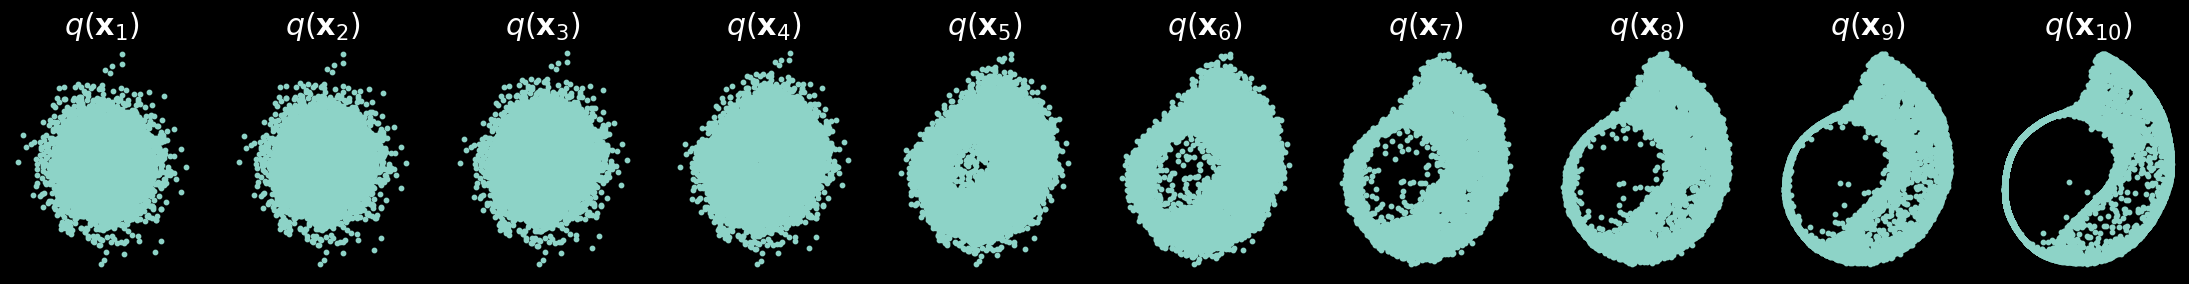

Loss: 0.1684984266757965:   9%|▊         | 428/5001 [07:35<1:04:16,  1.19it/s] findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found b

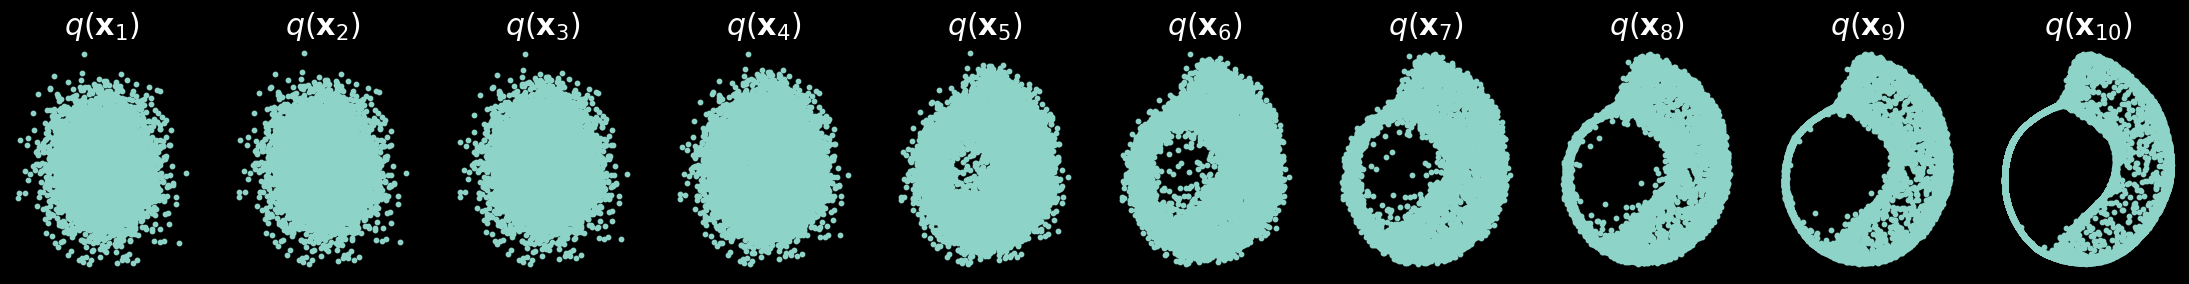

Loss: 0.17028406262397766:  11%|█         | 532/5001 [09:06<54:56,  1.36it/s]  findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found b

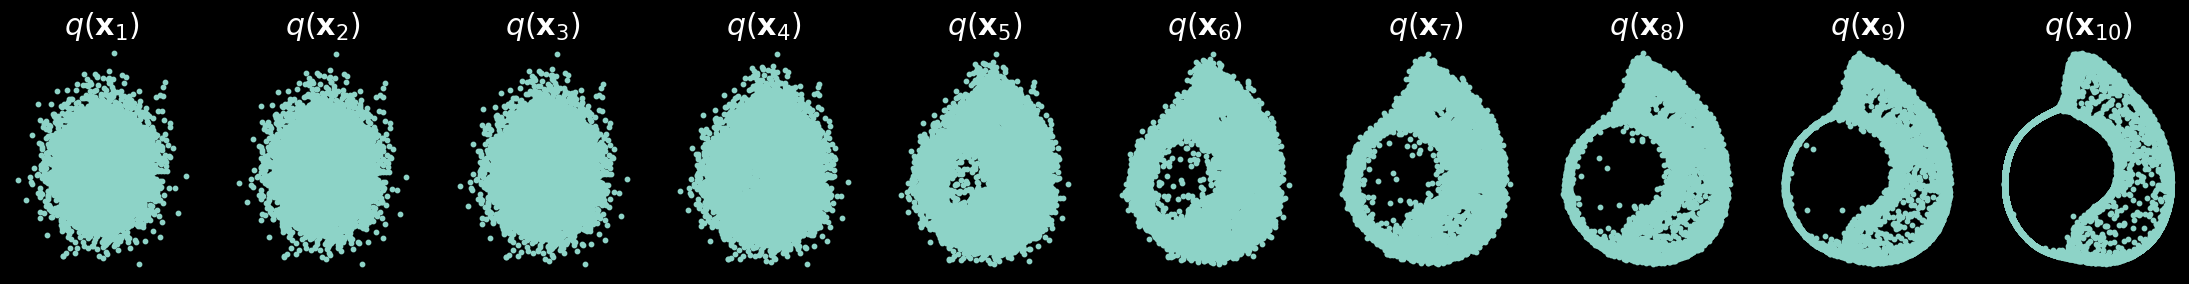

Loss: 0.6956772804260254:  13%|█▎        | 635/5001 [10:36<1:10:15,  1.04it/s] findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found b

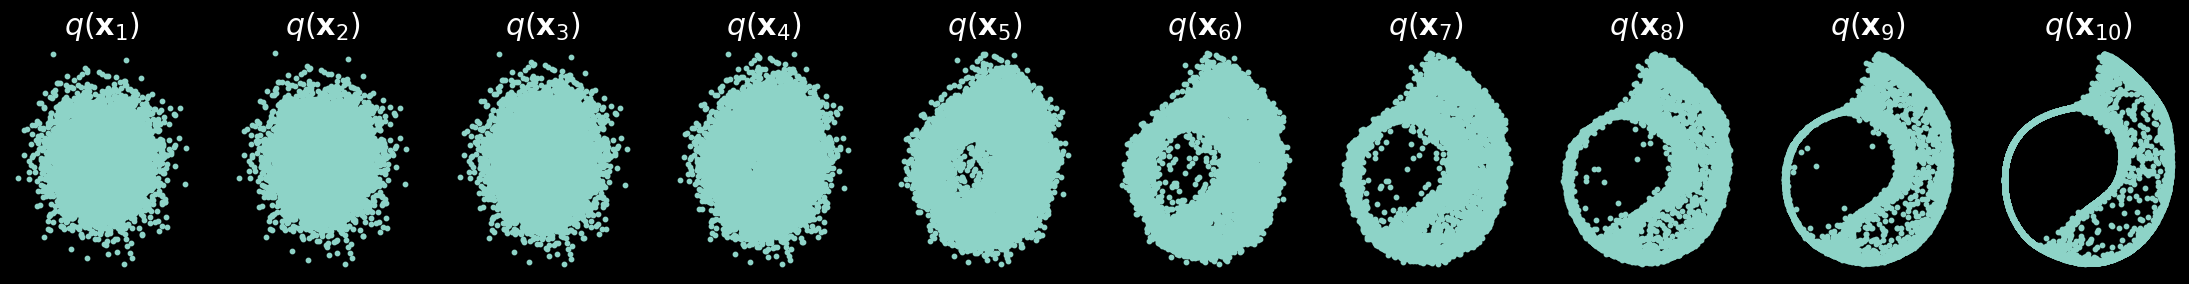

Loss: 0.27480176091194153:  15%|█▍        | 737/5001 [12:30<1:03:23,  1.12it/s] findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

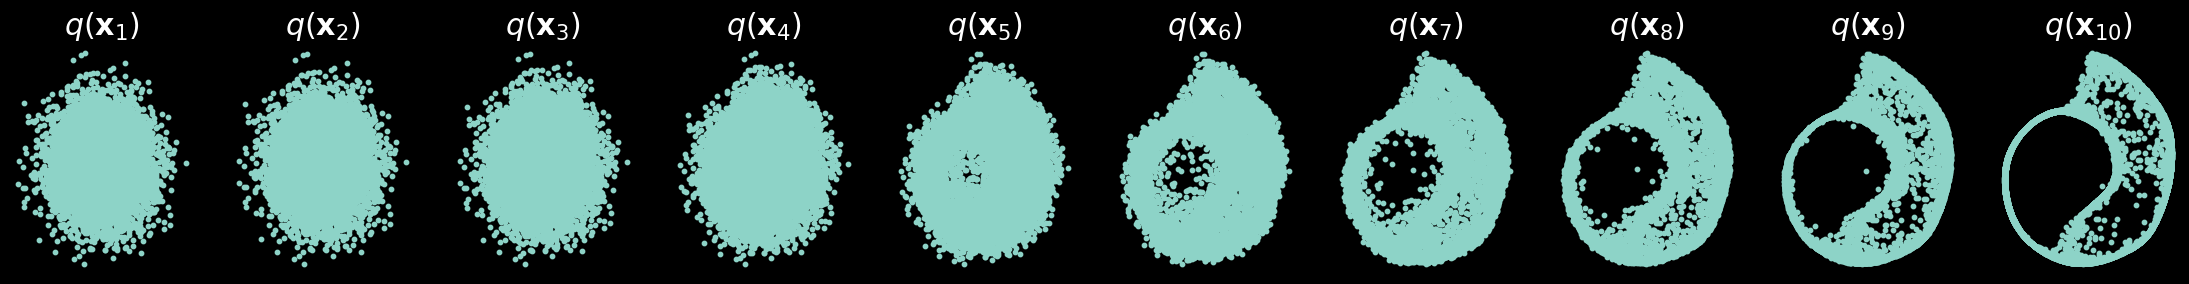

Loss: 0.5128129720687866:  17%|█▋        | 840/5001 [13:49<48:52,  1.42it/s]   findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found b

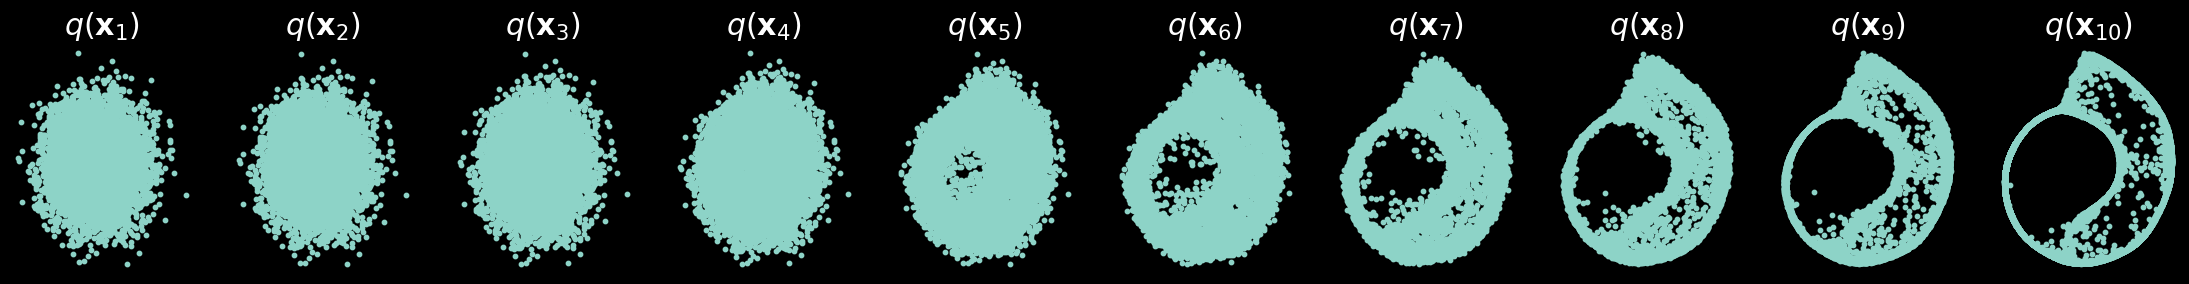

Loss: 0.34602394700050354:  19%|█▉        | 942/5001 [15:23<56:17,  1.20it/s]  findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found b

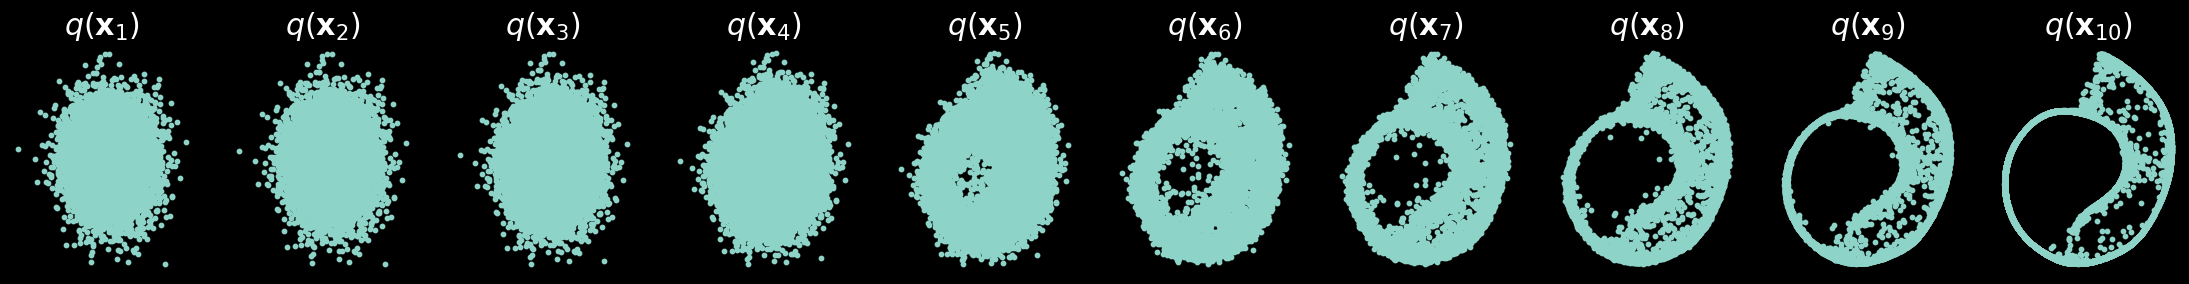

Loss: 0.47098106145858765:  21%|██        | 1045/5001 [16:39<1:06:37,  1.01s/it]findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

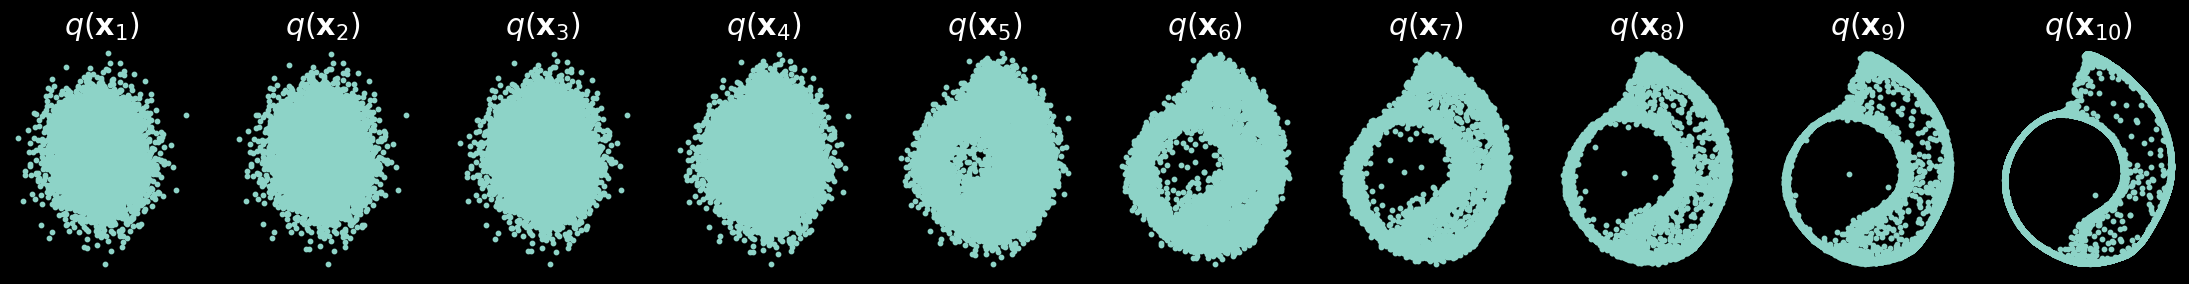

Loss: 0.1387982964515686:  23%|██▎       | 1147/5001 [18:13<1:09:44,  1.09s/it] findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

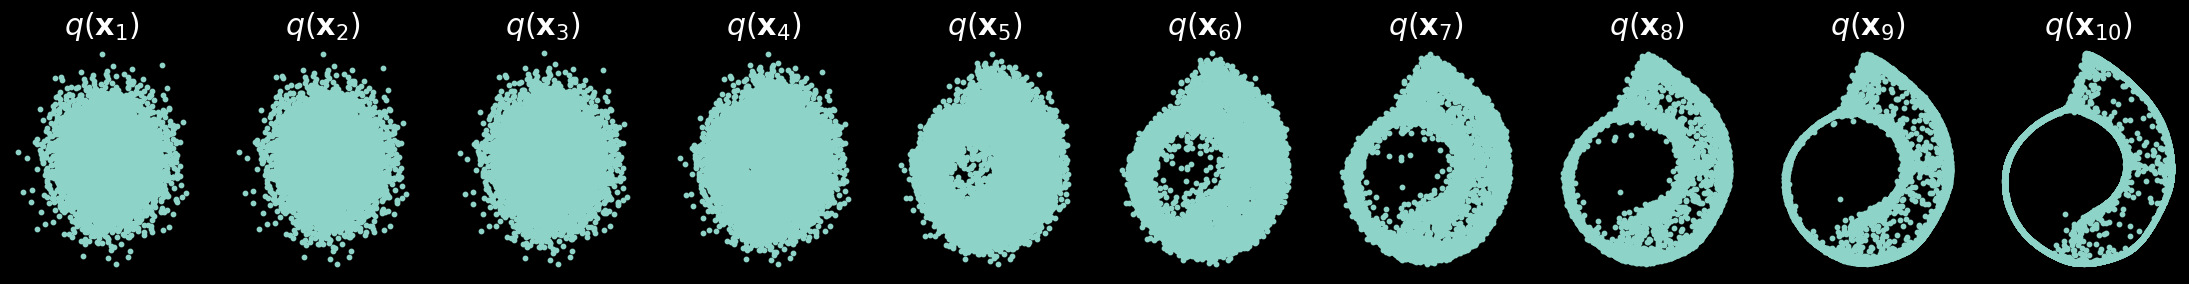

Loss: 0.3340422213077545:  25%|██▍       | 1249/5001 [19:40<52:02,  1.20it/s]   findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

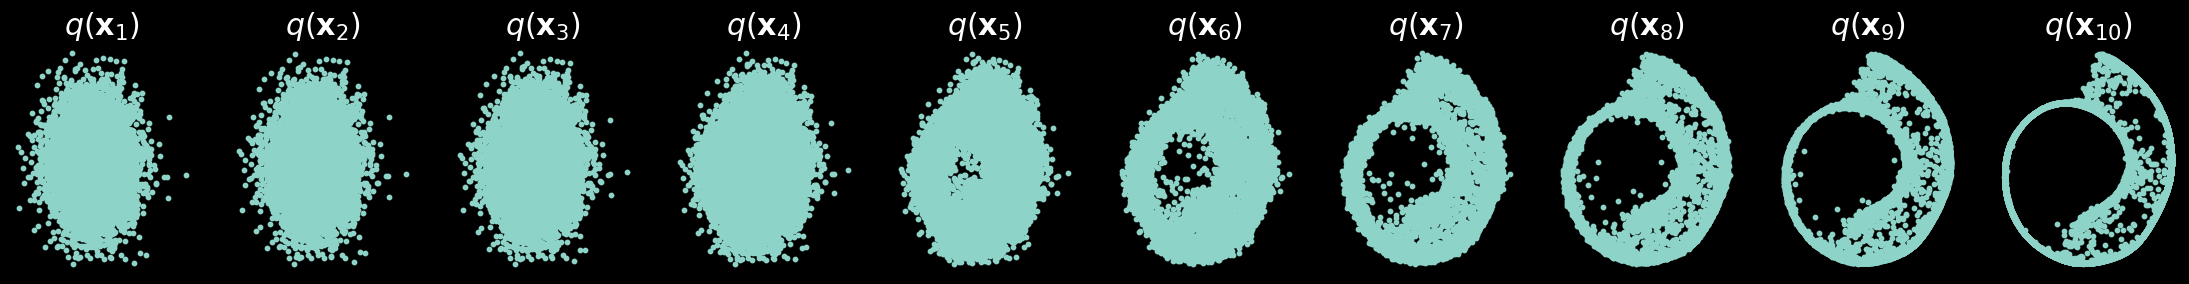

Loss: 0.5408656597137451:  27%|██▋       | 1351/5001 [21:03<41:17,  1.47it/s]  findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found b

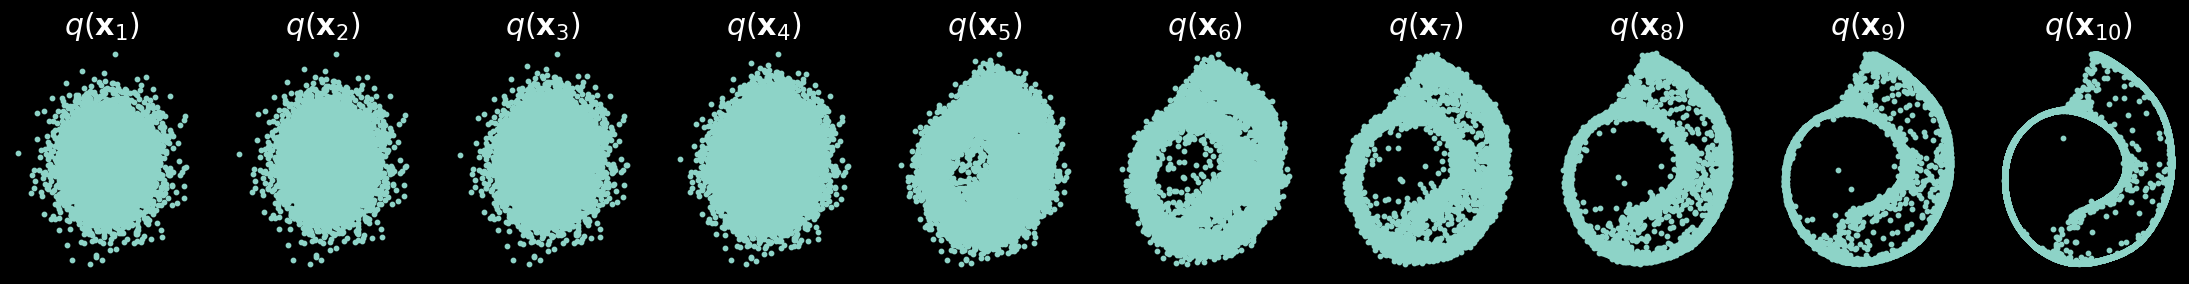

Loss: 0.3690868616104126:  29%|██▉       | 1453/5001 [22:17<41:19,  1.43it/s]  findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found b

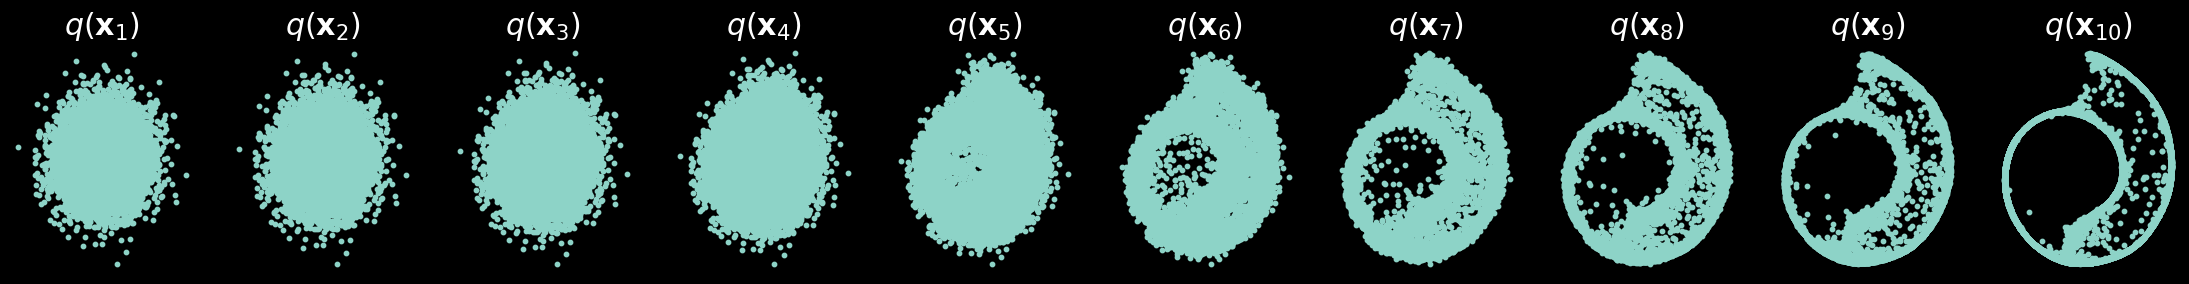

Loss: 0.2087070196866989:  31%|███       | 1555/5001 [23:32<40:56,  1.40it/s]  findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found b

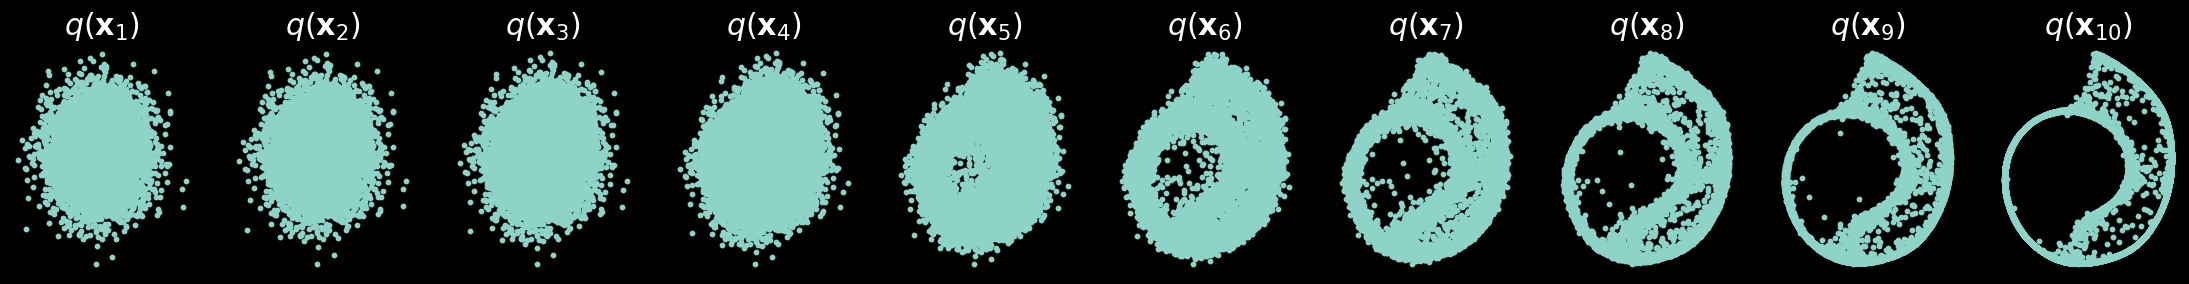

Loss: 0.31103867292404175:  33%|███▎      | 1657/5001 [24:56<34:49,  1.60it/s]  findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

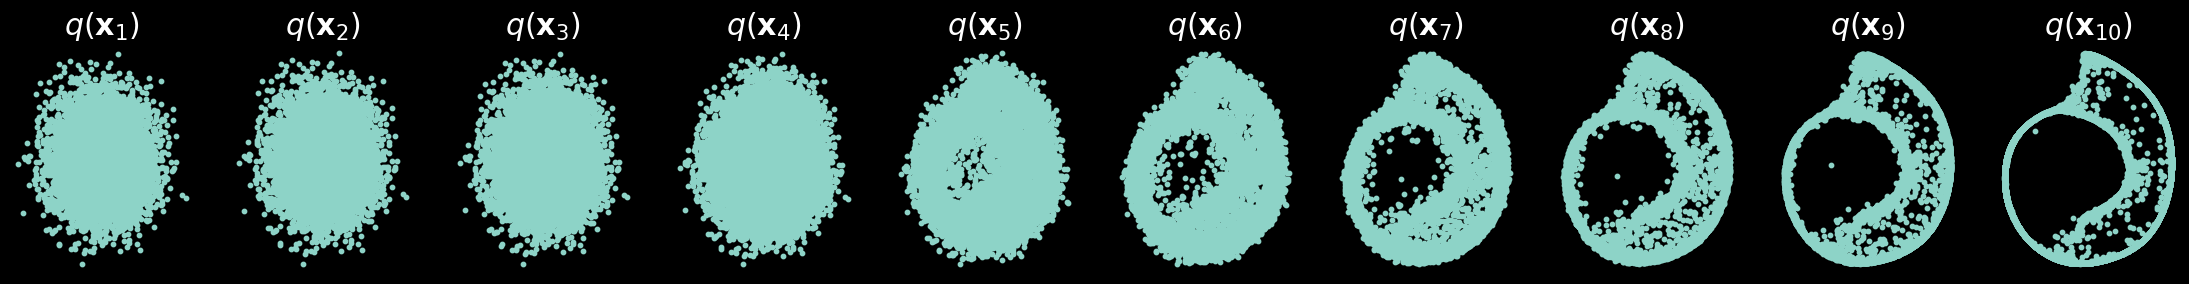

Loss: 0.3643508553504944:  35%|███▌      | 1758/5001 [26:33<45:40,  1.18it/s]   findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

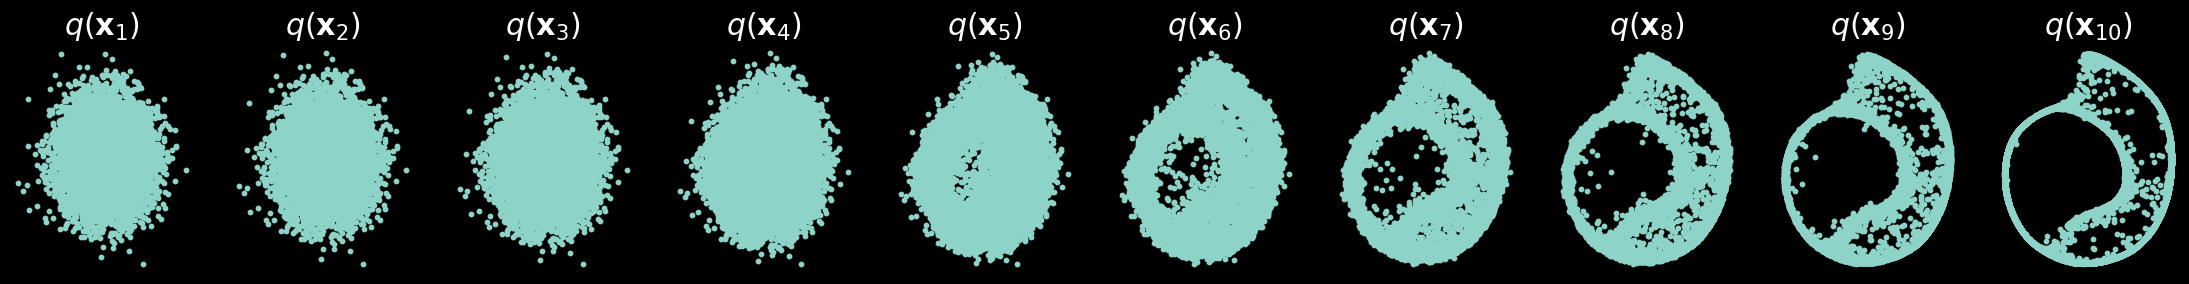

Loss: 0.486727237701416:  37%|███▋      | 1860/5001 [28:07<45:13,  1.16it/s]   findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found b

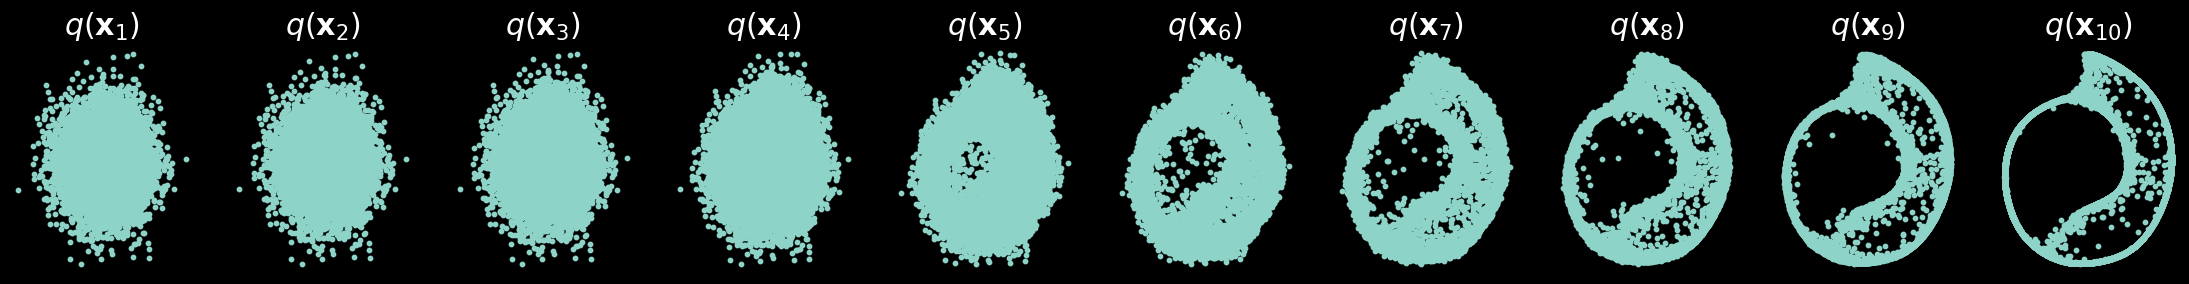

Loss: 0.17463134229183197:  39%|███▉      | 1962/5001 [29:24<52:14,  1.03s/it]findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found be

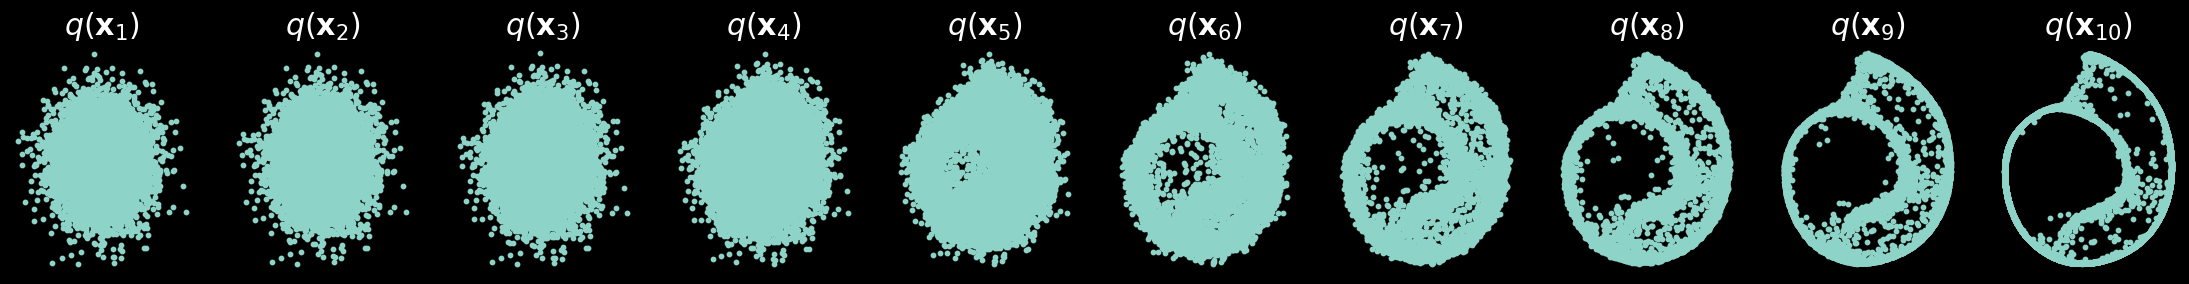

Loss: 0.21261151134967804:  41%|████▏     | 2063/5001 [31:07<49:09,  1.00s/it]  findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

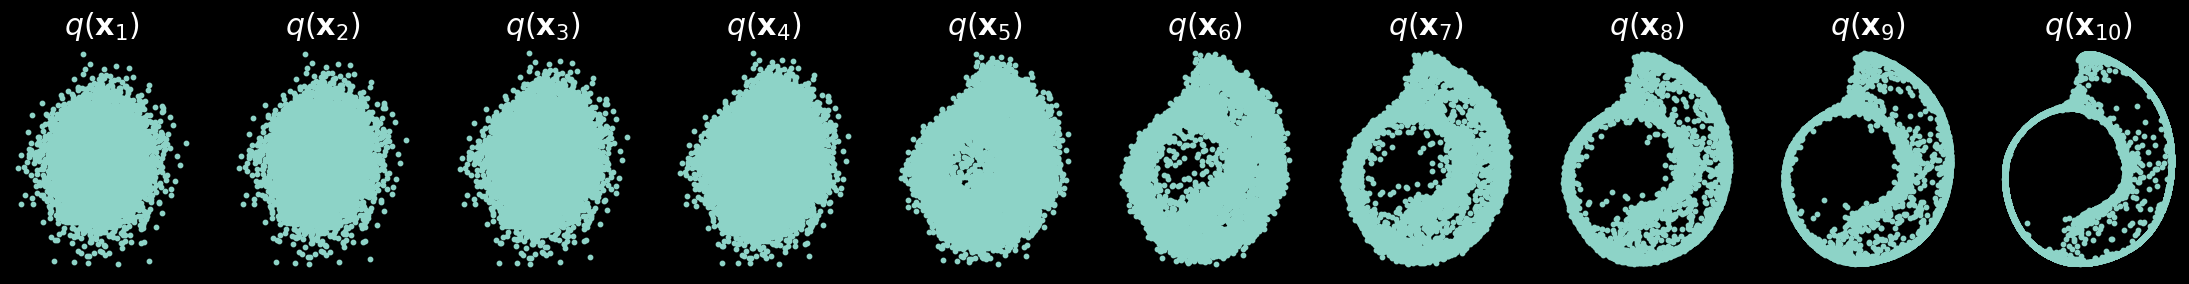

Loss: 0.19778525829315186:  43%|████▎     | 2165/5001 [32:34<35:12,  1.34it/s]  findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

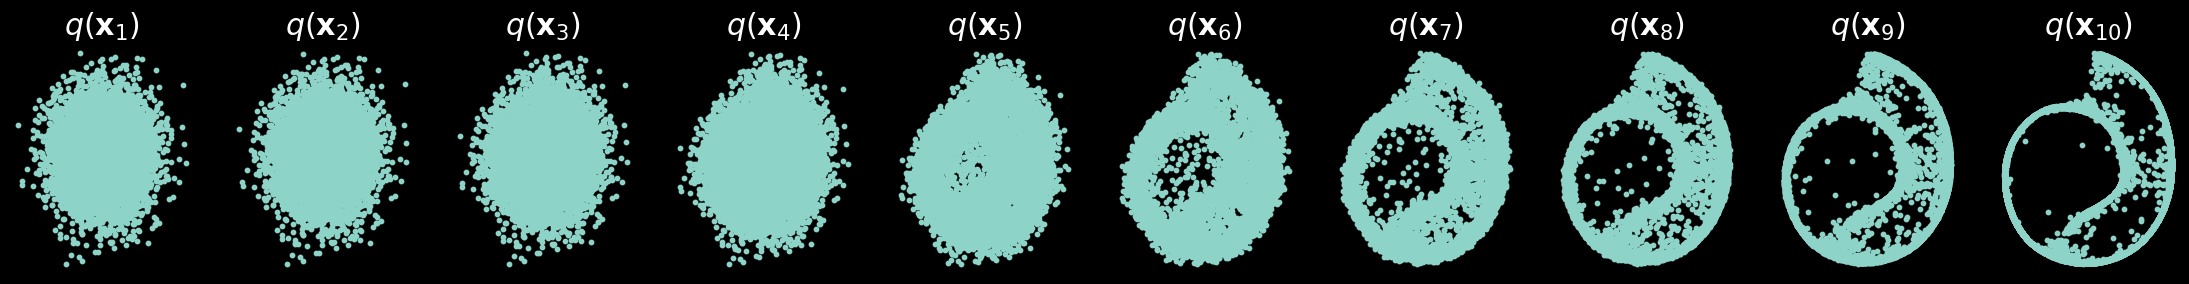

Loss: 0.33234304189682007:  45%|████▌     | 2266/5001 [34:09<40:16,  1.13it/s]  findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

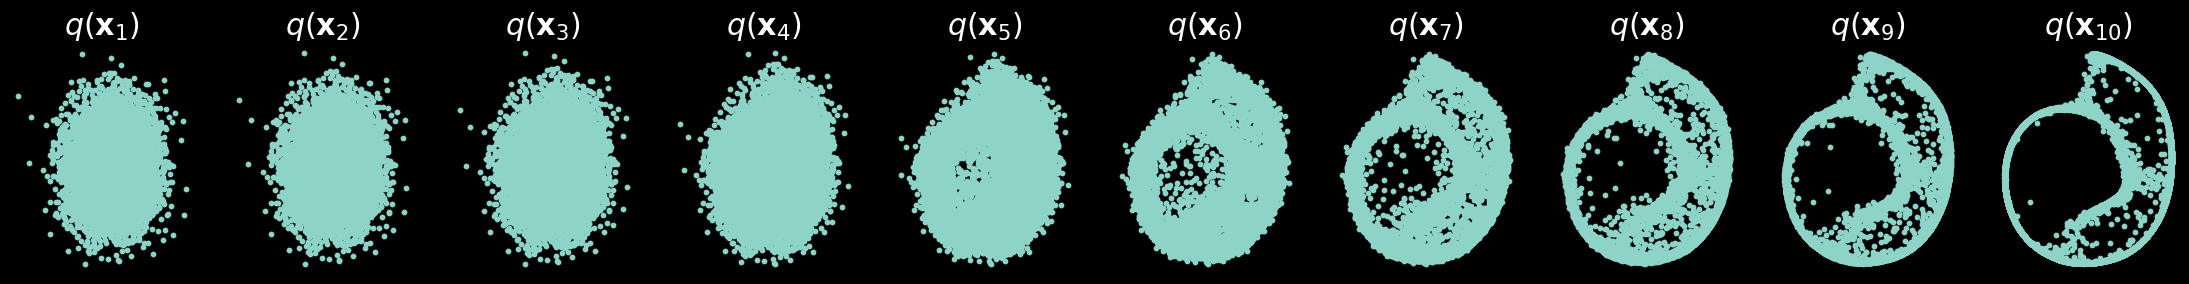

Loss: 0.5120618939399719:  47%|████▋     | 2368/5001 [35:40<41:03,  1.07it/s]   findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

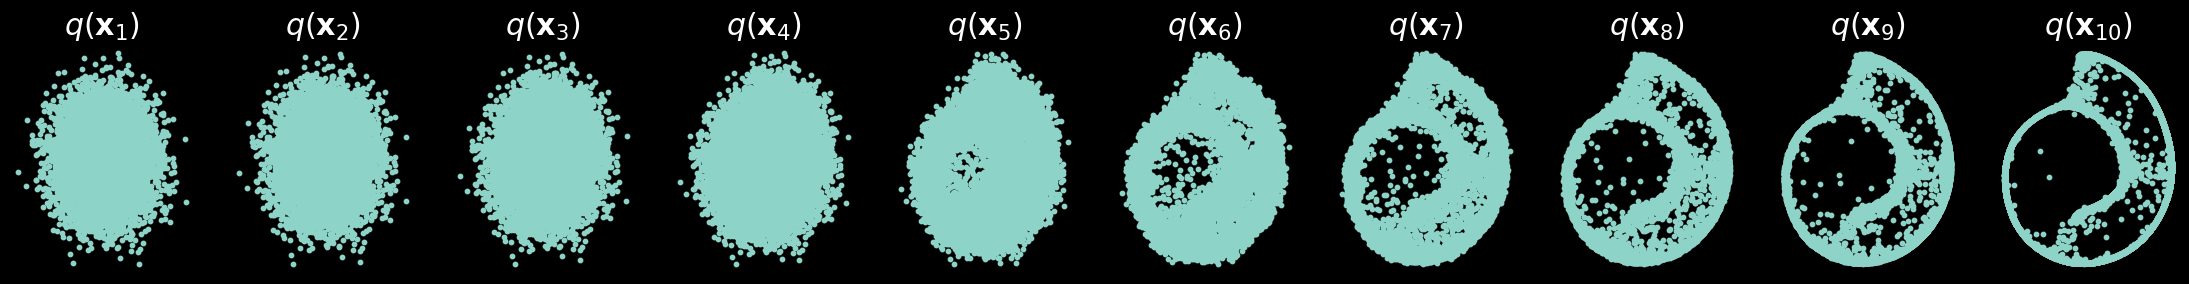

Loss: 0.1741502583026886:  49%|████▉     | 2469/5001 [37:23<38:25,  1.10it/s]  findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found b

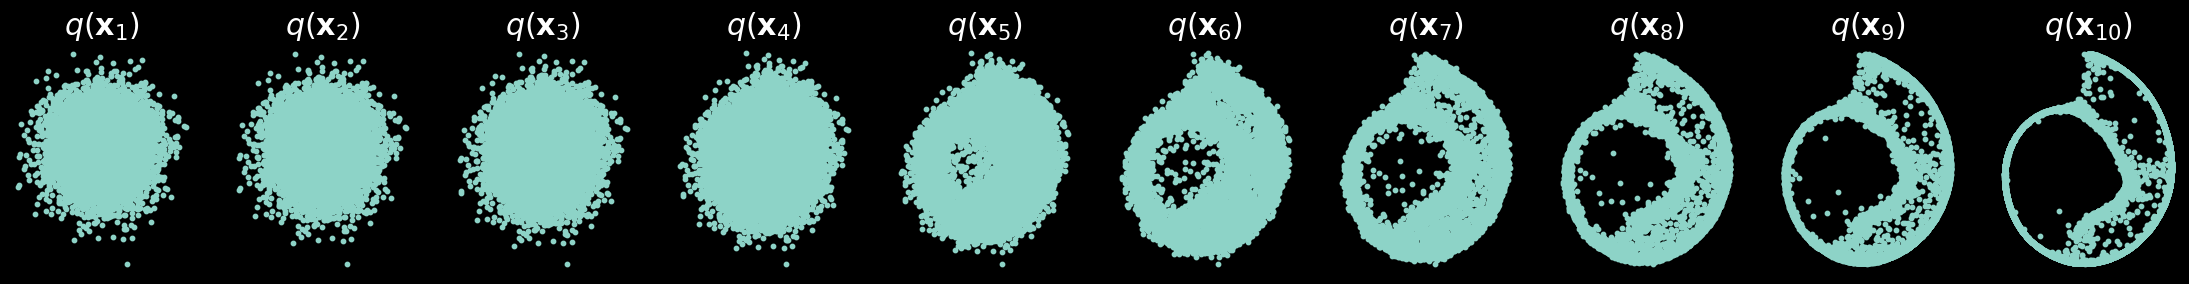

Loss: 0.3692377209663391:  51%|█████▏    | 2571/5001 [39:03<44:06,  1.09s/it]  findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found b

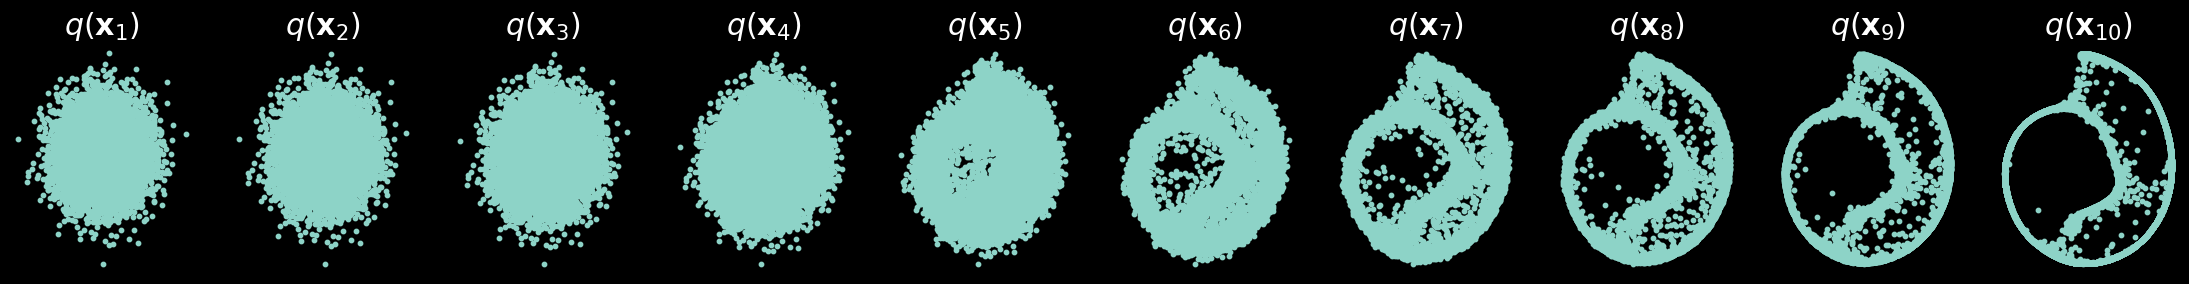

Loss: 0.4244224429130554:  53%|█████▎    | 2672/5001 [40:30<27:14,  1.42it/s]  findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found b

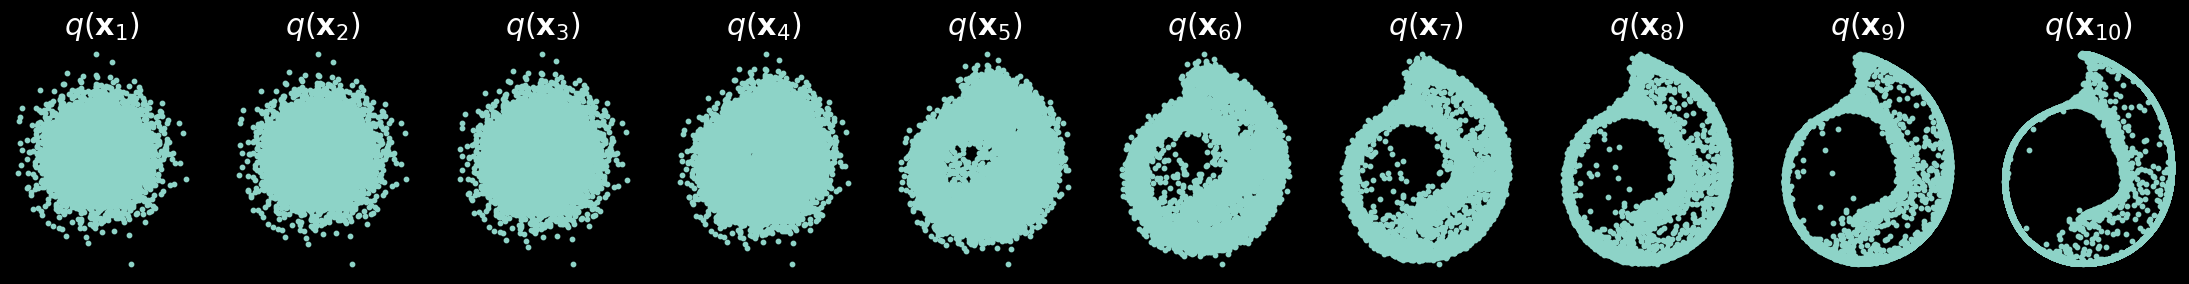

Loss: 0.32926905155181885:  55%|█████▌    | 2773/5001 [41:45<27:51,  1.33it/s] findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found b

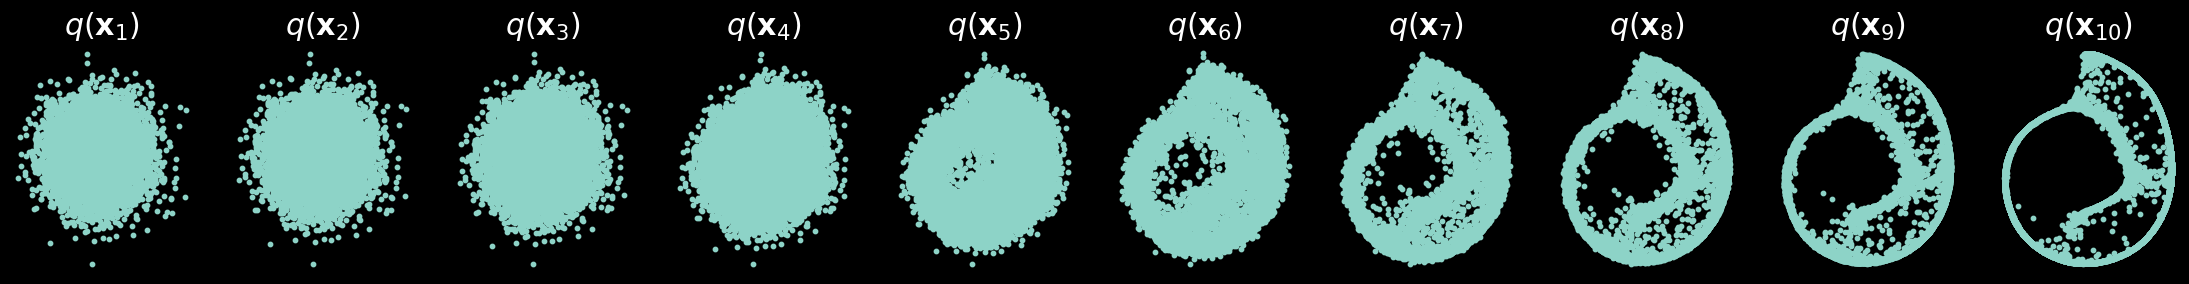

Loss: 0.6078156232833862:  57%|█████▋    | 2875/5001 [43:13<30:53,  1.15it/s]   findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

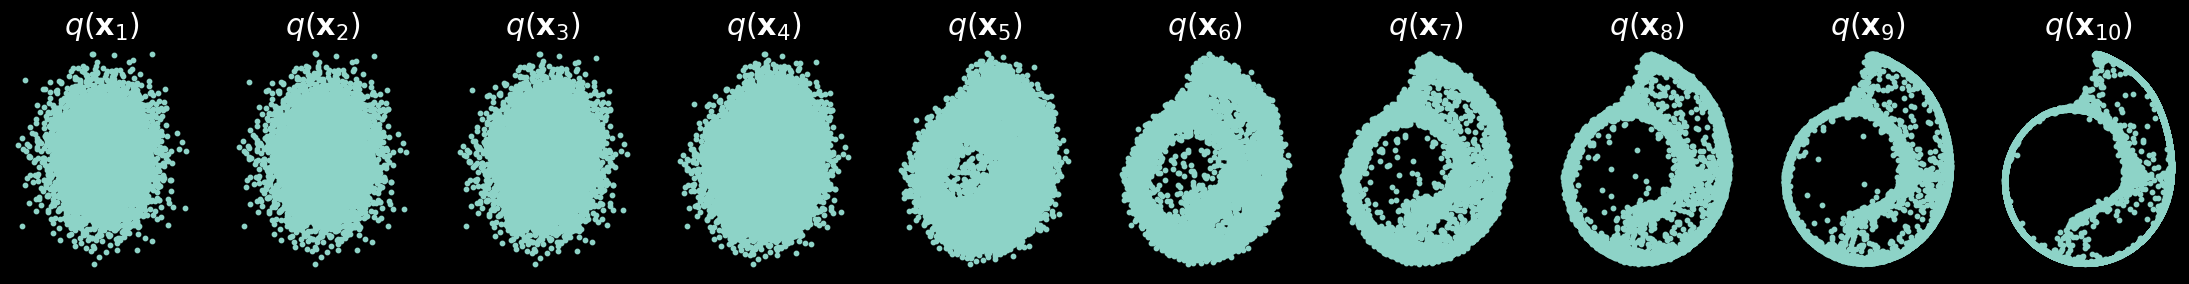

Loss: 0.4262002110481262:  60%|█████▉    | 2976/5001 [44:29<23:40,  1.43it/s]  findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found b

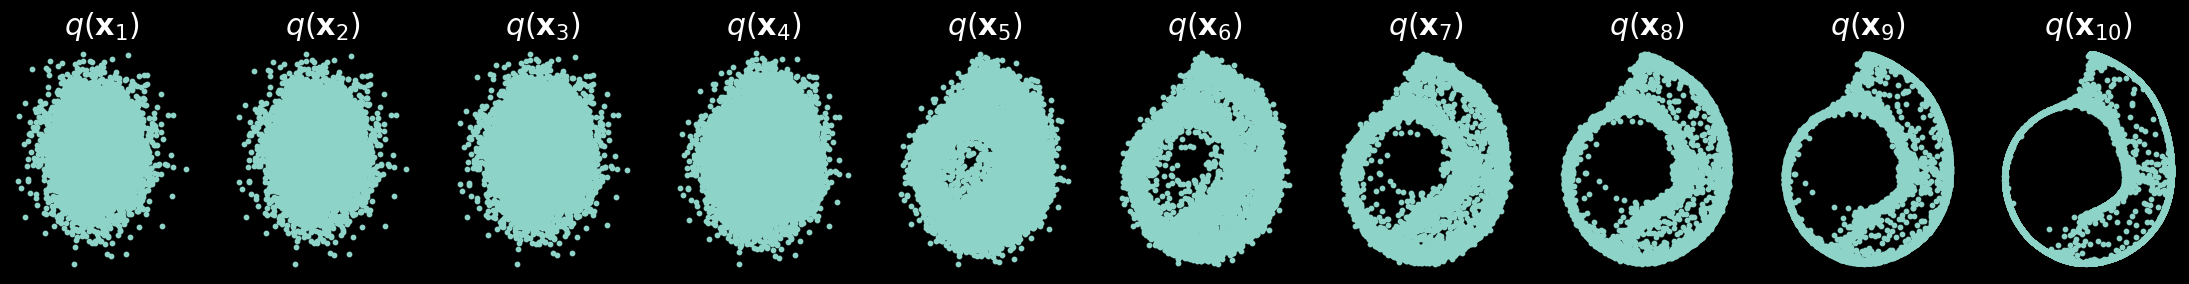

Loss: 0.11096961051225662:  62%|██████▏   | 3077/5001 [45:44<22:01,  1.46it/s]findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found be

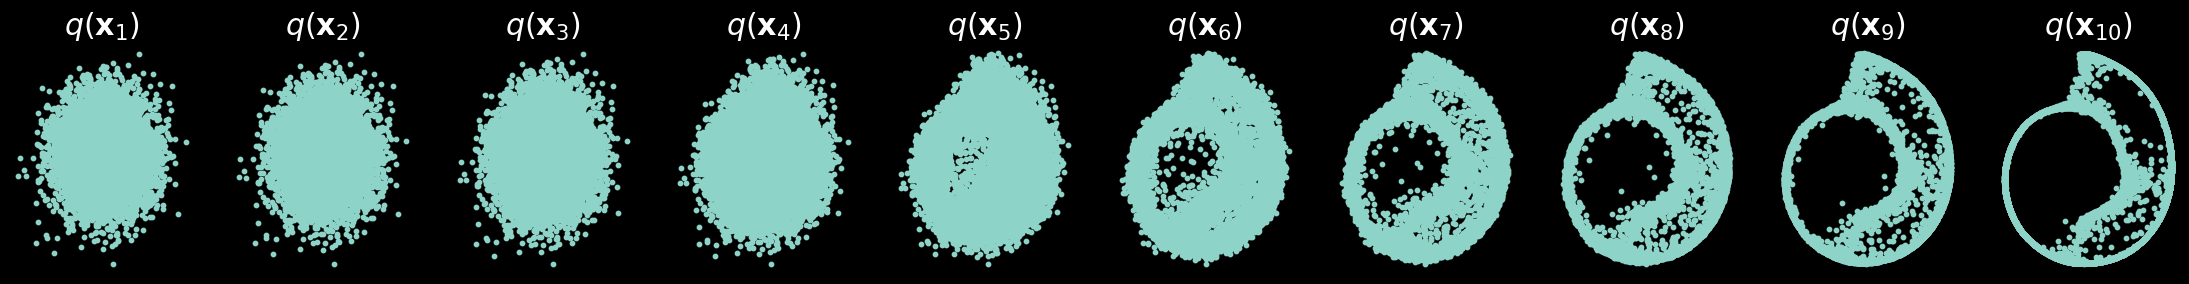

Loss: 0.1035739853978157:  64%|██████▎   | 3179/5001 [47:00<21:16,  1.43it/s] findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found be

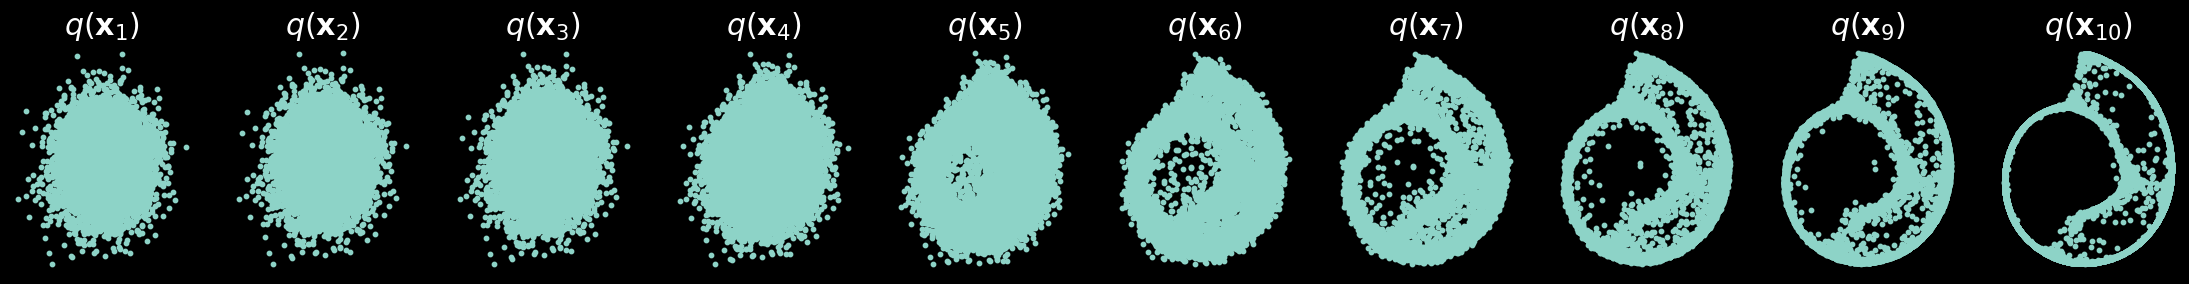

Loss: 0.530818521976471:  66%|██████▌   | 3280/5001 [48:17<20:57,  1.37it/s]  findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found be

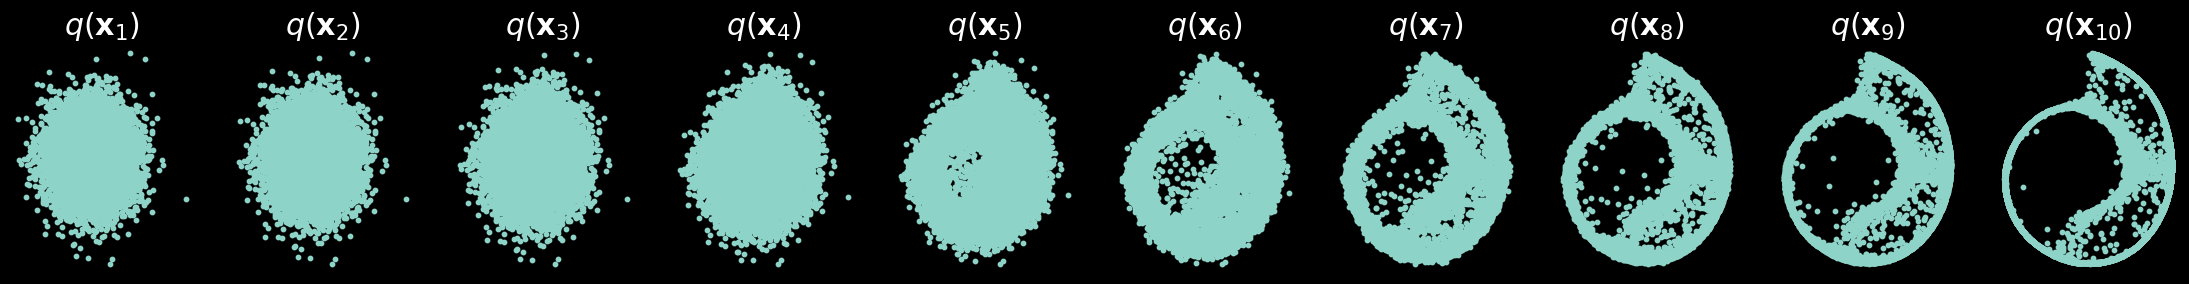

Loss: 0.26830703020095825:  68%|██████▊   | 3381/5001 [49:36<22:50,  1.18it/s]findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found be

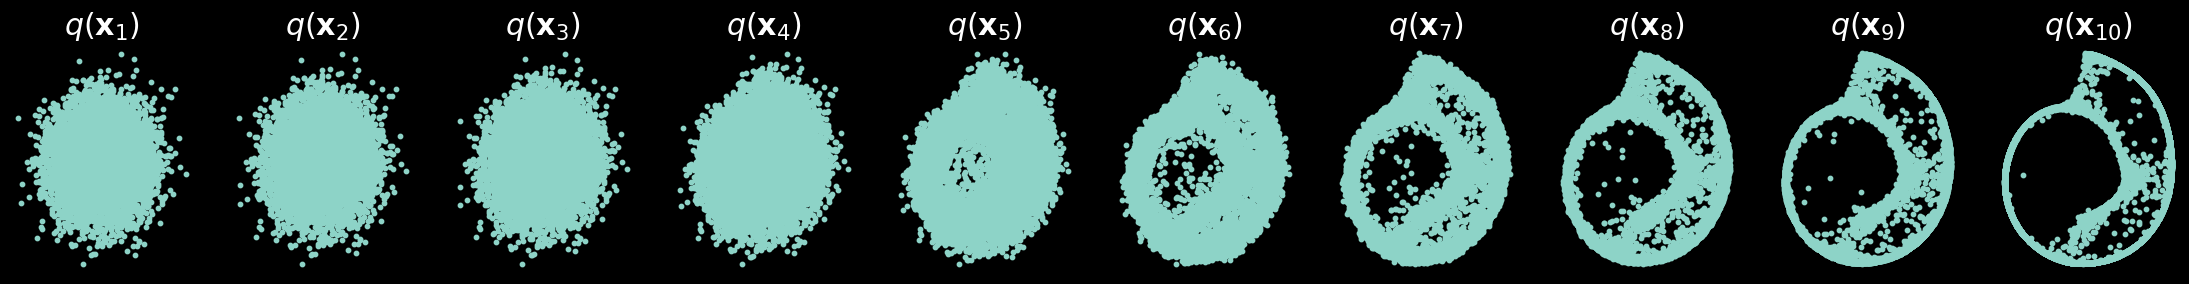

Loss: 0.40472733974456787:  70%|██████▉   | 3482/5001 [50:52<18:05,  1.40it/s]findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found be

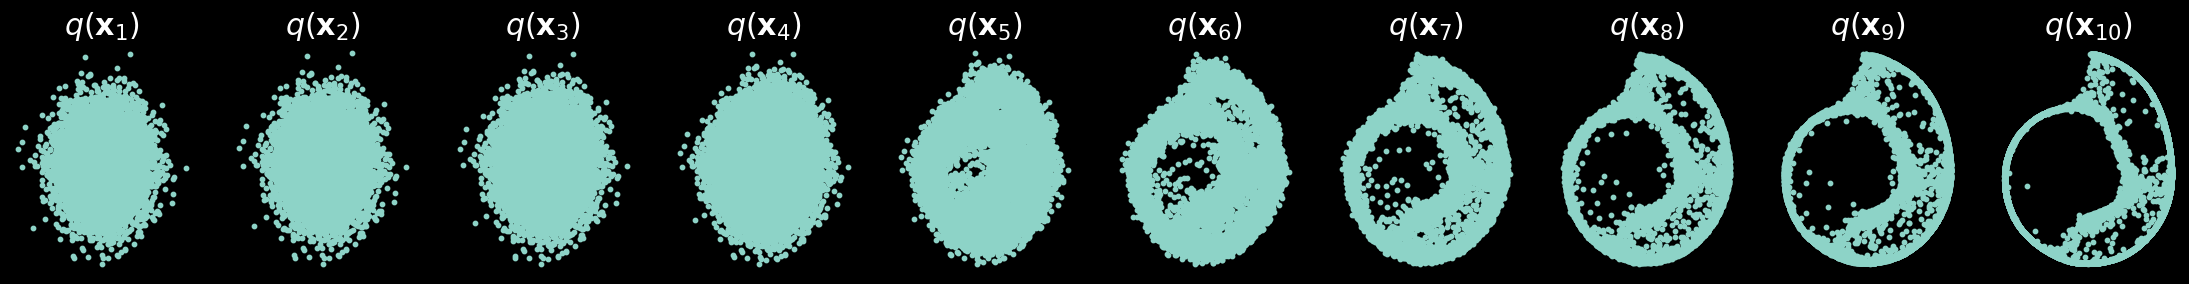

Loss: 0.3749878406524658:  72%|███████▏  | 3584/5001 [52:07<17:06,  1.38it/s] findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found be

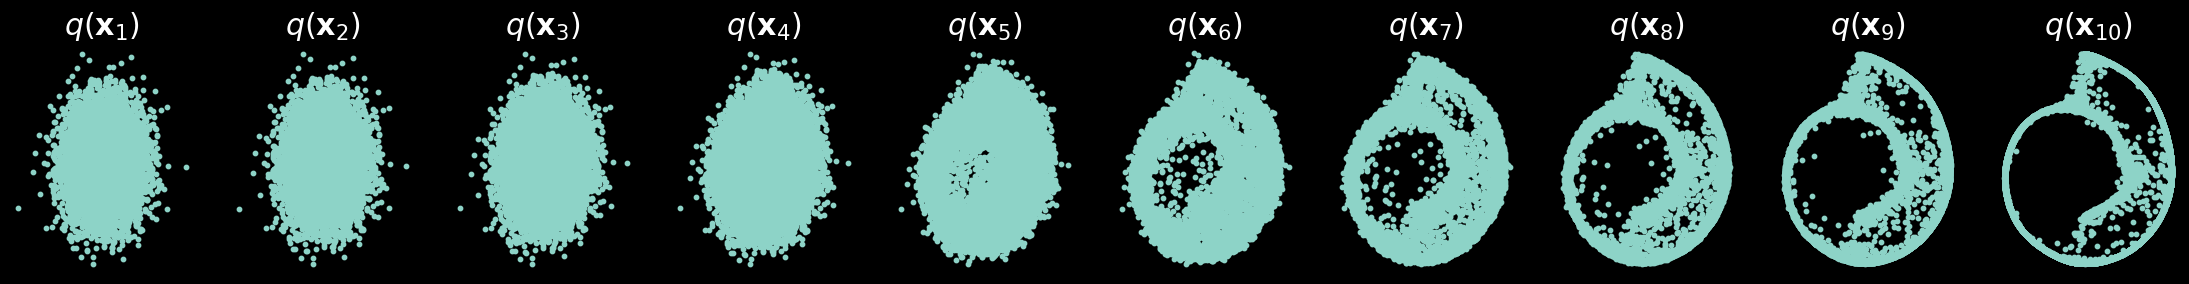

Loss: 0.5171457529067993:  74%|███████▎  | 3685/5001 [53:23<15:43,  1.39it/s] findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found be

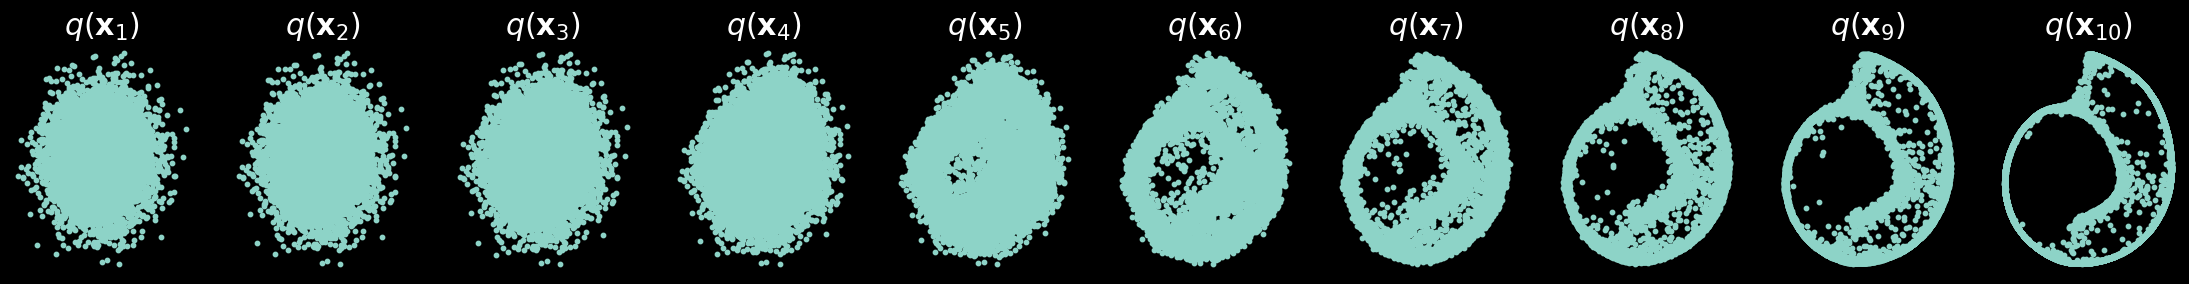

Loss: 0.4006164073944092:  76%|███████▌  | 3786/5001 [54:38<14:24,  1.40it/s] findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found be

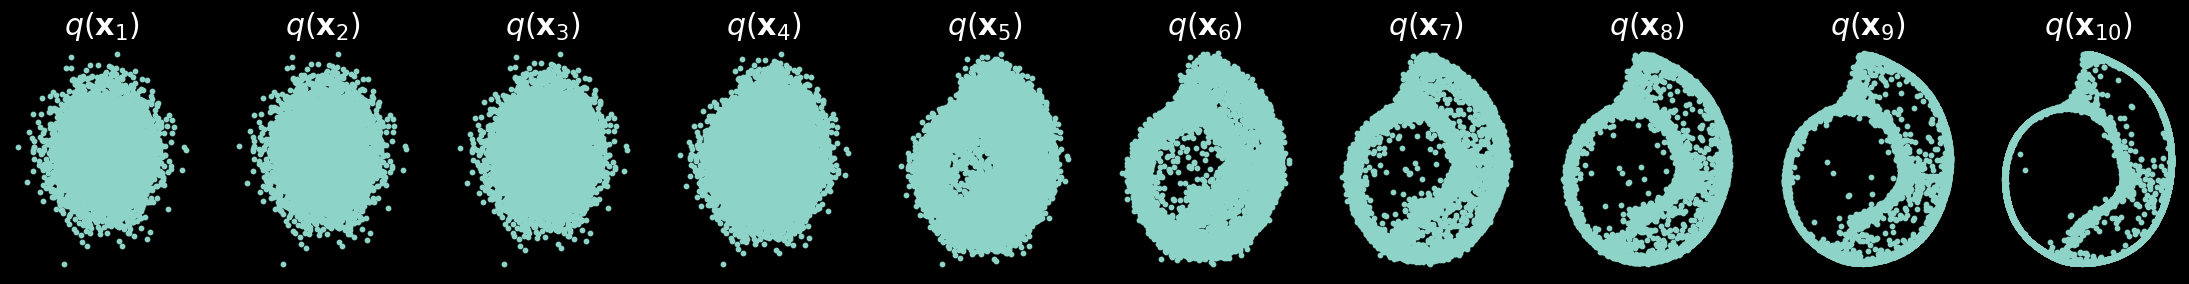

Loss: 0.43796736001968384:  78%|███████▊  | 3887/5001 [55:53<13:32,  1.37it/s]findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found be

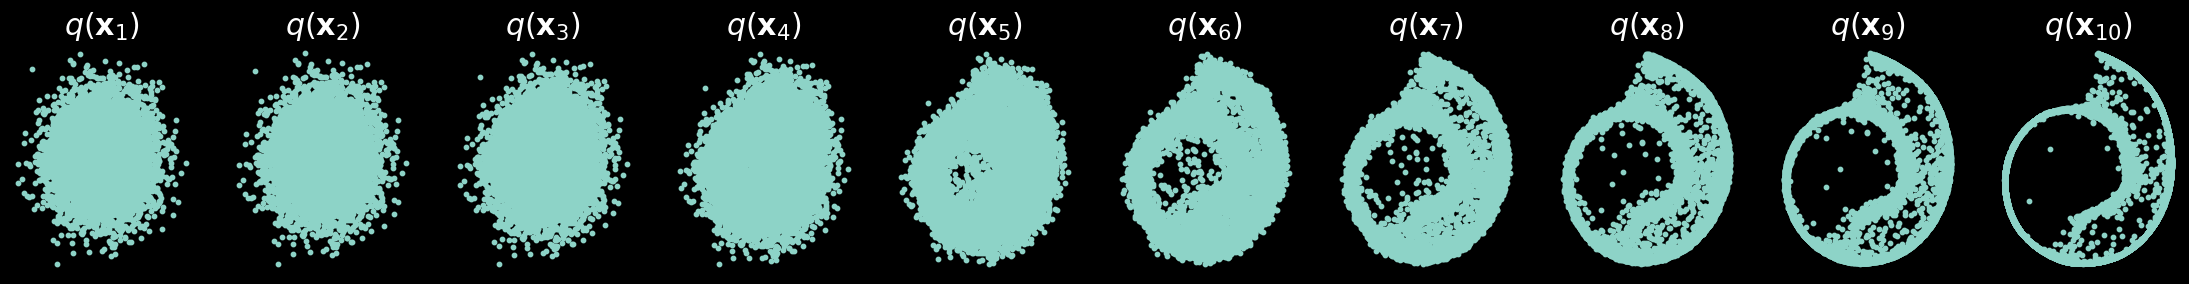

Loss: 0.3282999098300934:  80%|███████▉  | 3988/5001 [57:18<18:33,  1.10s/it] findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found be

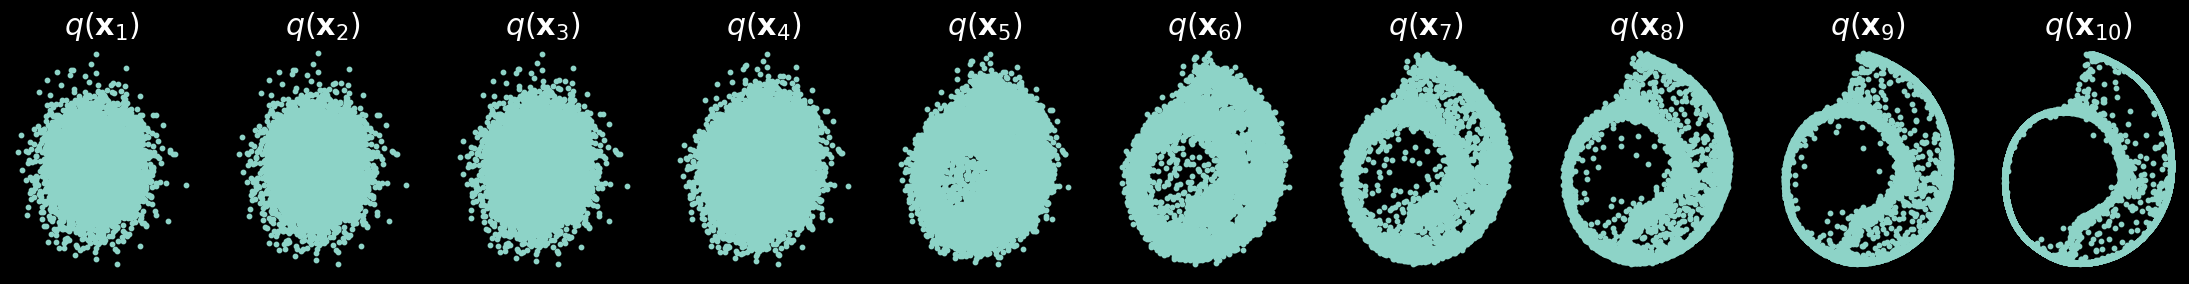

Loss: 0.212309330701828:  82%|████████▏ | 4089/5001 [58:48<14:04,  1.08it/s]  findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found be

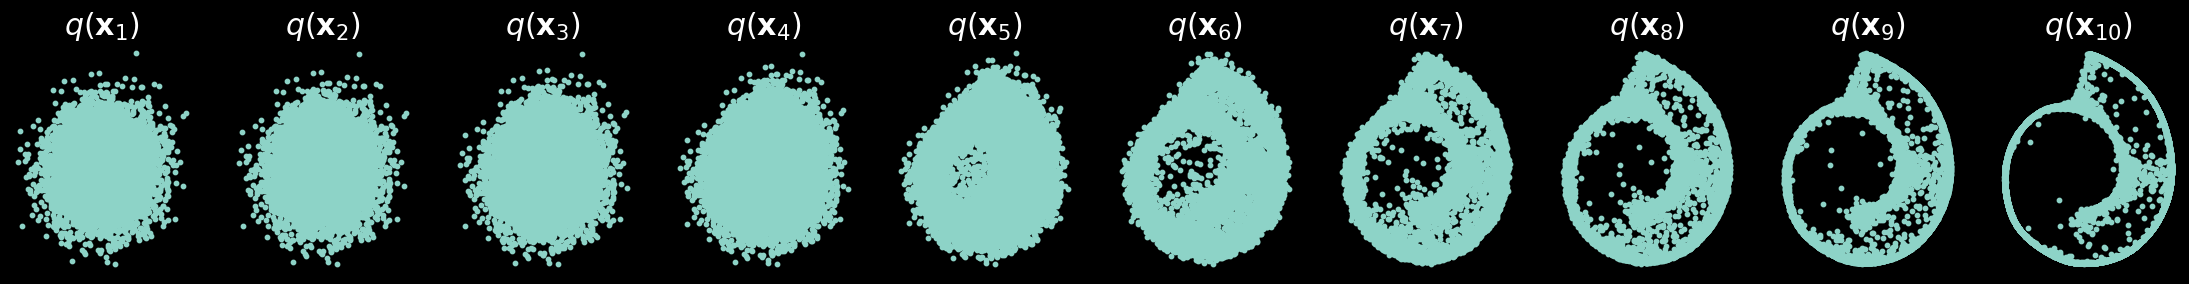

Loss: 0.20193780958652496:  84%|████████▍ | 4191/5001 [1:00:38<12:49,  1.05it/s]findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

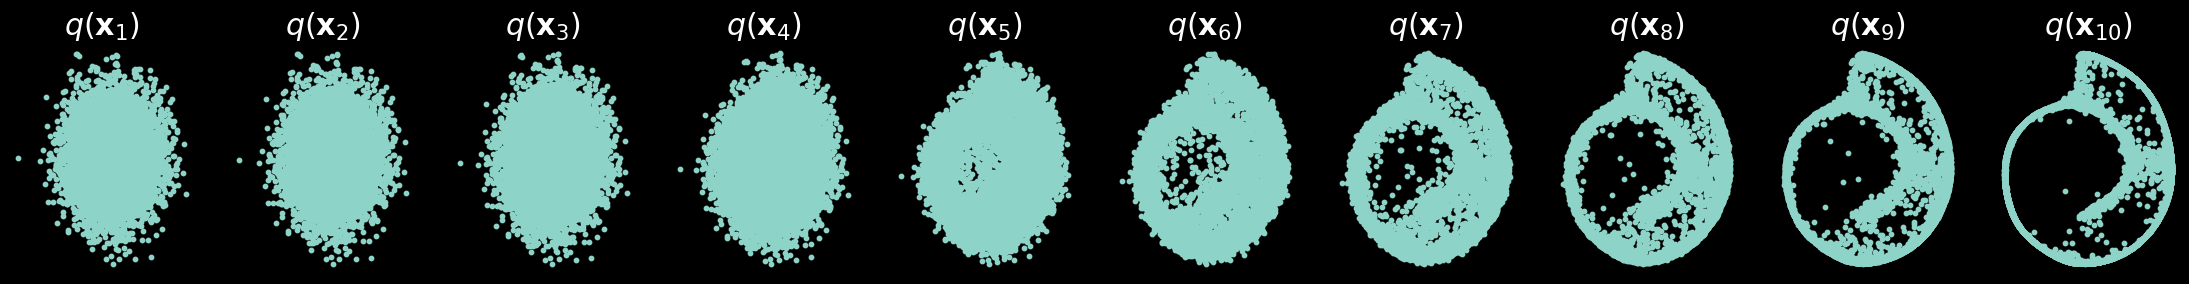

Loss: 0.3933735191822052:  86%|████████▌ | 4292/5001 [1:02:12<09:09,  1.29it/s] findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

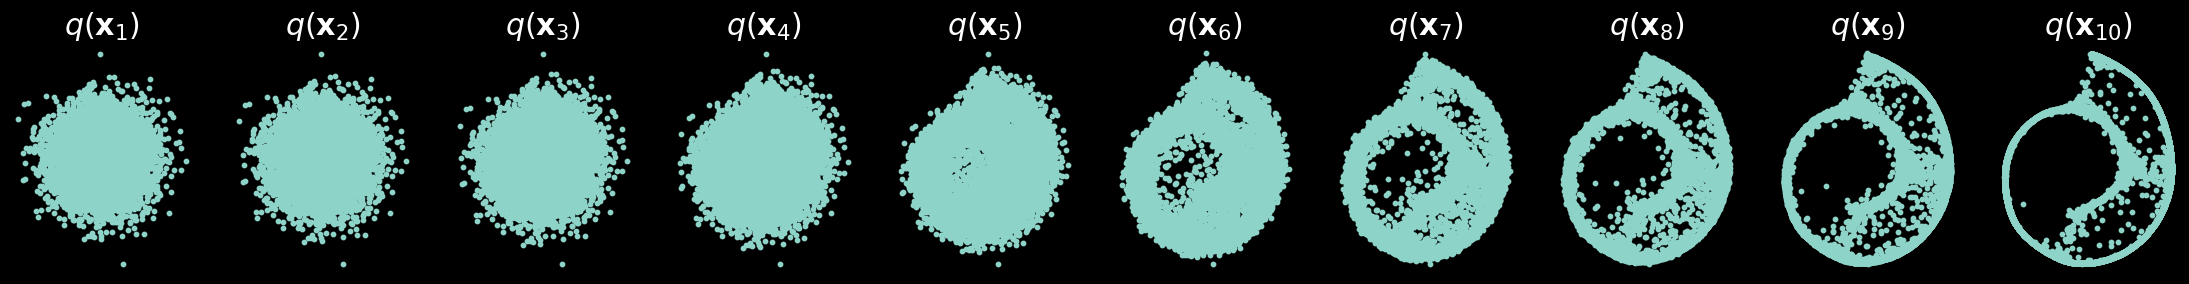

Loss: 0.3743783235549927:  88%|████████▊ | 4393/5001 [1:03:33<07:34,  1.34it/s] findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

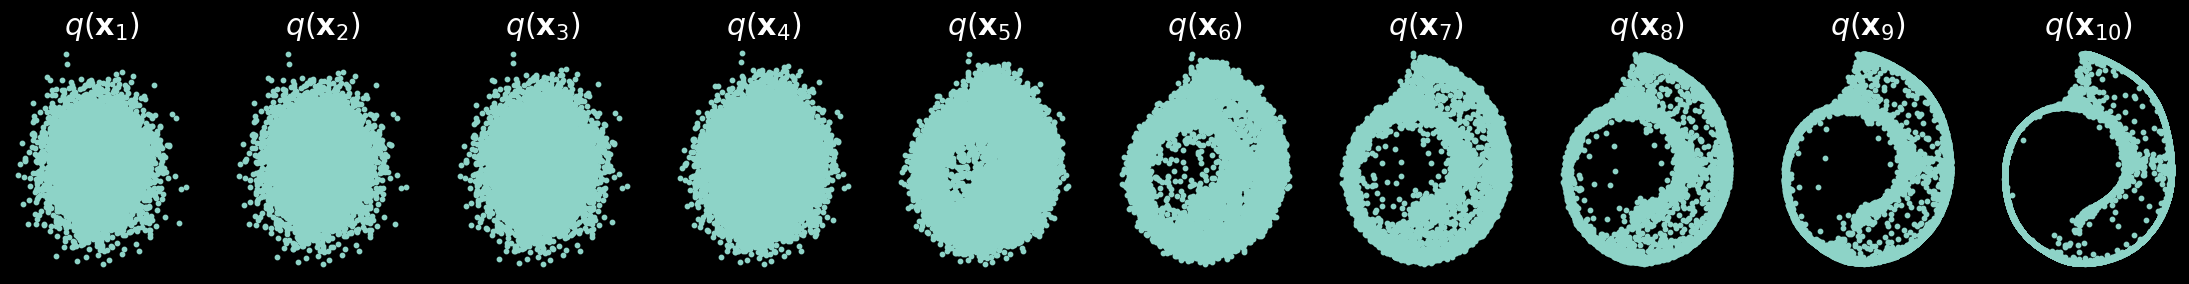

Loss: 0.5218591690063477:  90%|████████▉ | 4494/5001 [1:04:57<06:09,  1.37it/s] findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

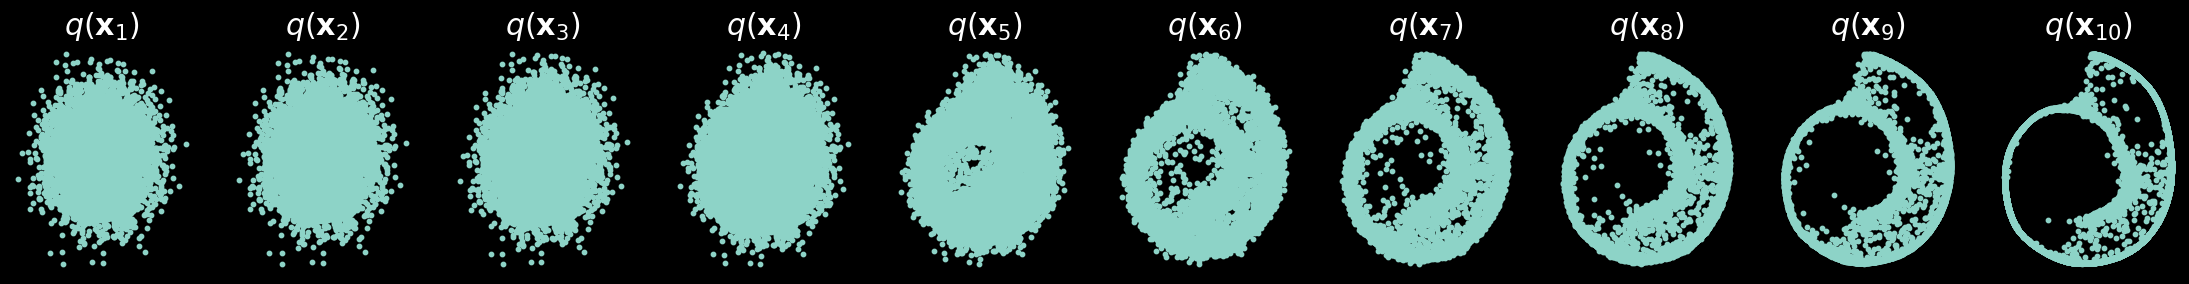

Loss: 0.36982807517051697:  92%|█████████▏| 4595/5001 [1:06:20<04:45,  1.42it/s]findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

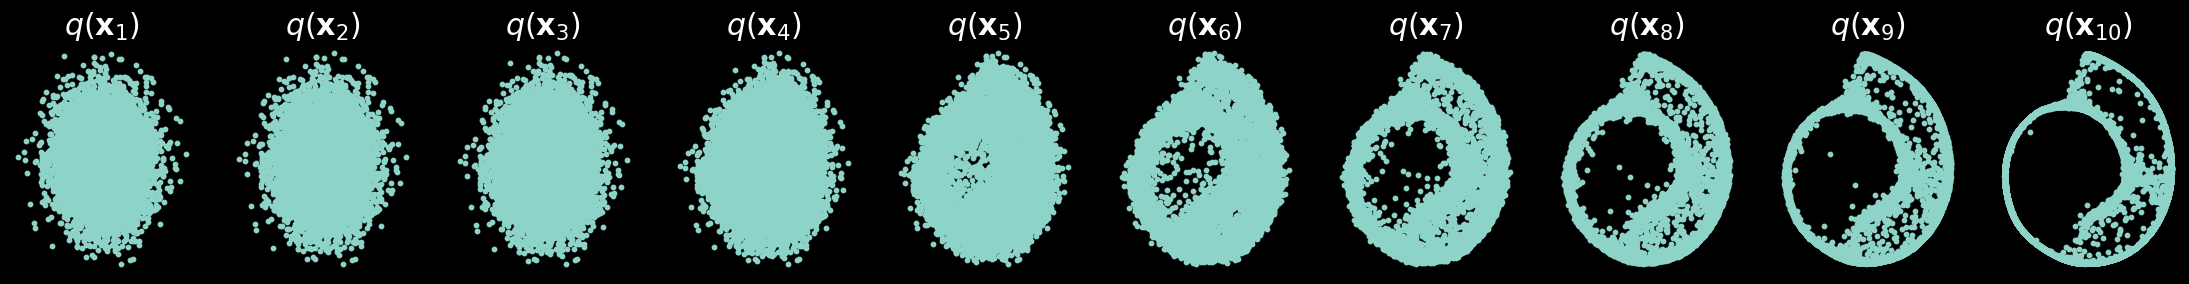

Loss: 0.2733916938304901:  94%|█████████▍| 4696/5001 [1:07:38<05:09,  1.02s/it] findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

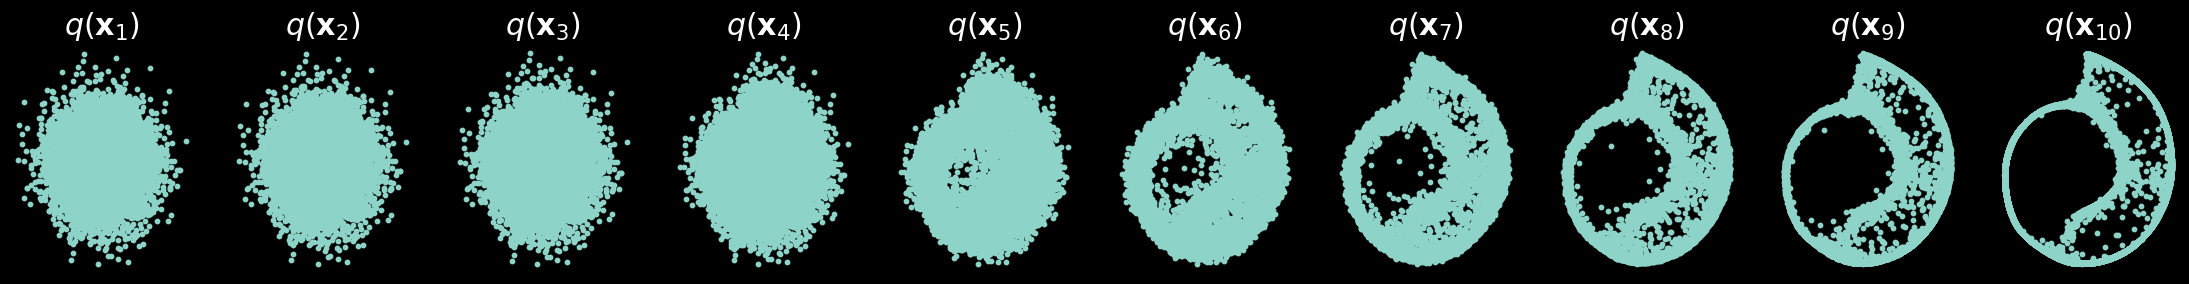

Loss: 0.28973937034606934:  96%|█████████▌| 4797/5001 [1:08:57<02:43,  1.25it/s]findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

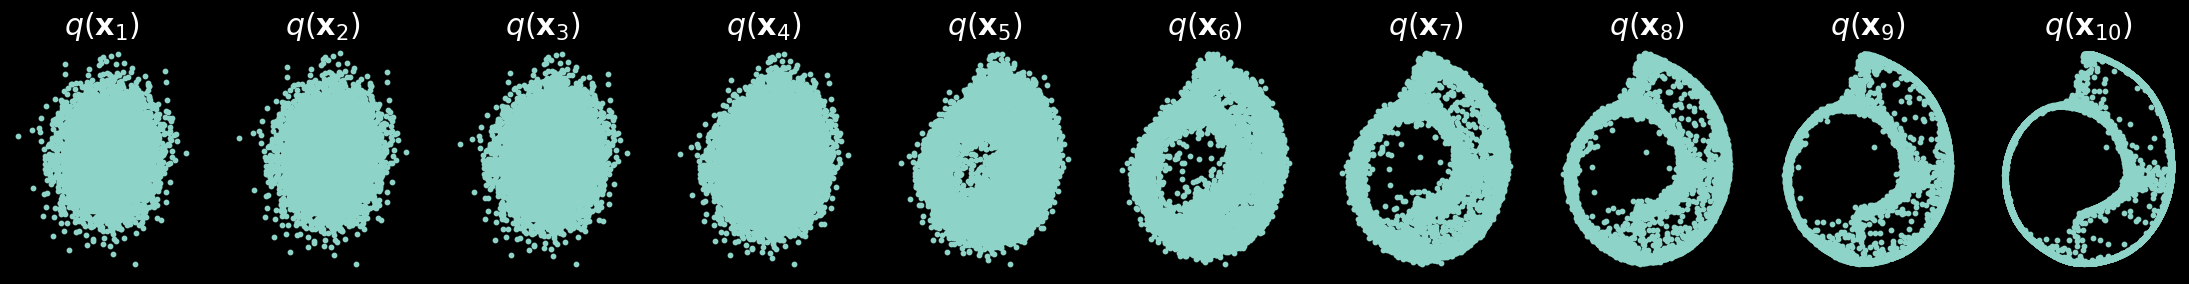

Loss: 0.38929885625839233:  98%|█████████▊| 4898/5001 [1:10:15<01:19,  1.30it/s]findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

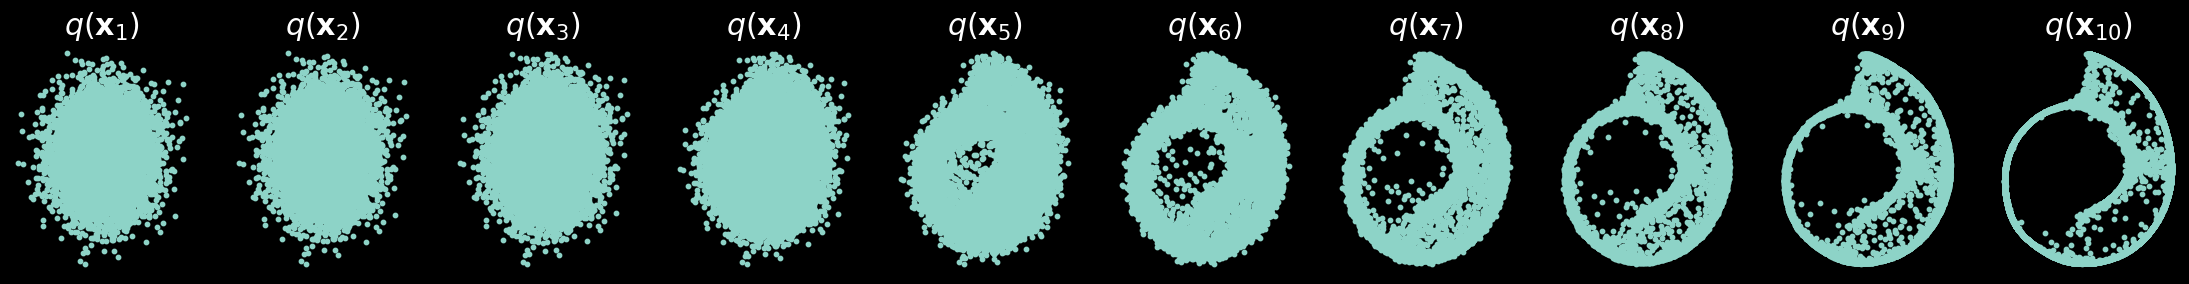

Loss: 0.6338649988174438: 100%|█████████▉| 4999/5001 [1:11:44<00:01,  1.45it/s] findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found 

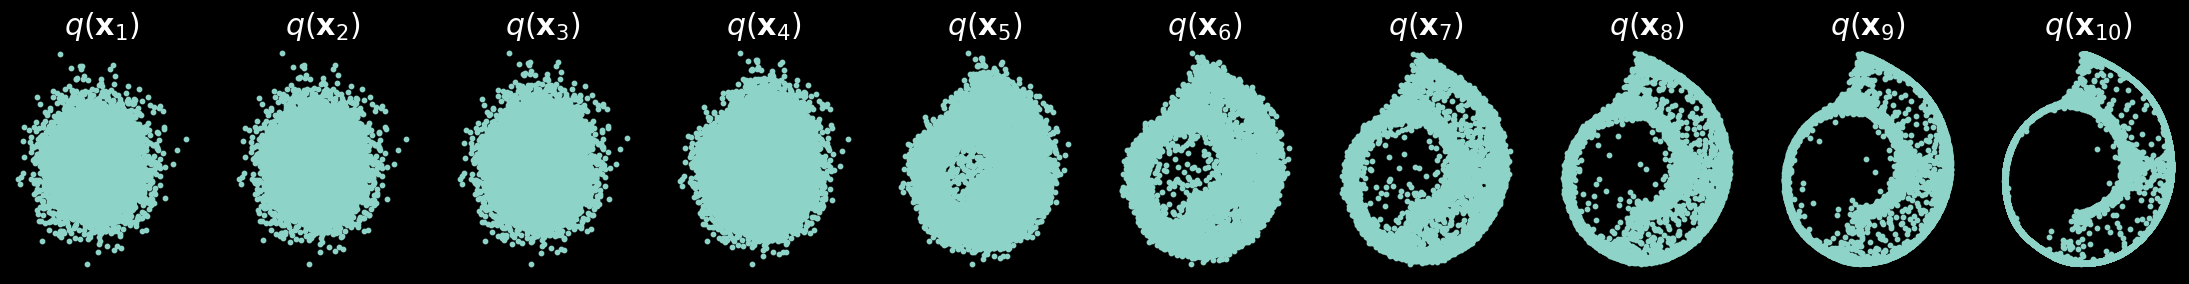

Loss: 0.232110396027565: : 5100it [1:13:11,  1.33it/s]                         findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found b

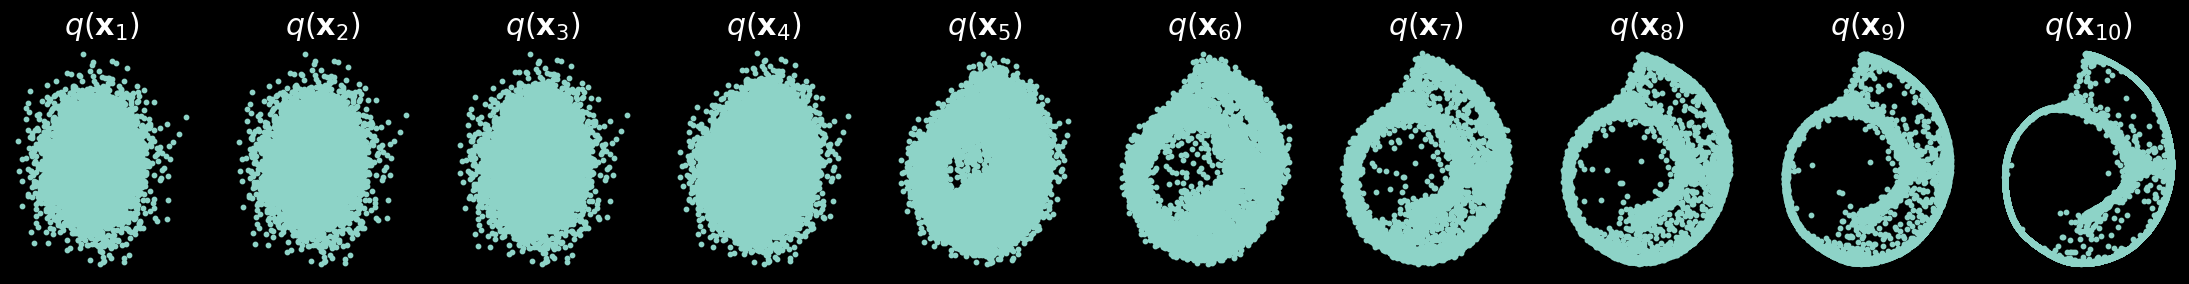

Loss: 0.232110396027565: 100%|██████████| 5001/5001 [1:13:15<00:00,  1.14it/s]


In [25]:
import tqdm 

model = DenoisingMLP(2, 256, 32)
optimizer = optim.Adam(model.parameters(), lr=5e-4)
dataset = torch.tensor(data.T).float()
batch_size = 32

pbar = tqdm.tqdm(range((5001)))

for t in pbar:
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        batch_x = batch_x
        loss = EDM_loss(batch_x, model)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        
        
    if (t%10==0):
        pbar.set_description(f"Loss: {loss}")
        
    # Print loss
    if (t % 100 == 0):
        x_seq = EDM_sampling(model, 61, dataset.shape[0])
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i*len(x_seq)//10-1].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10)
            axs[i-1].set_axis_off(); axs[i-1].set_title('$q(\mathbf{x}_{'+str(i)+'})$')
        plt.show()
        
    pbar.update(1)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

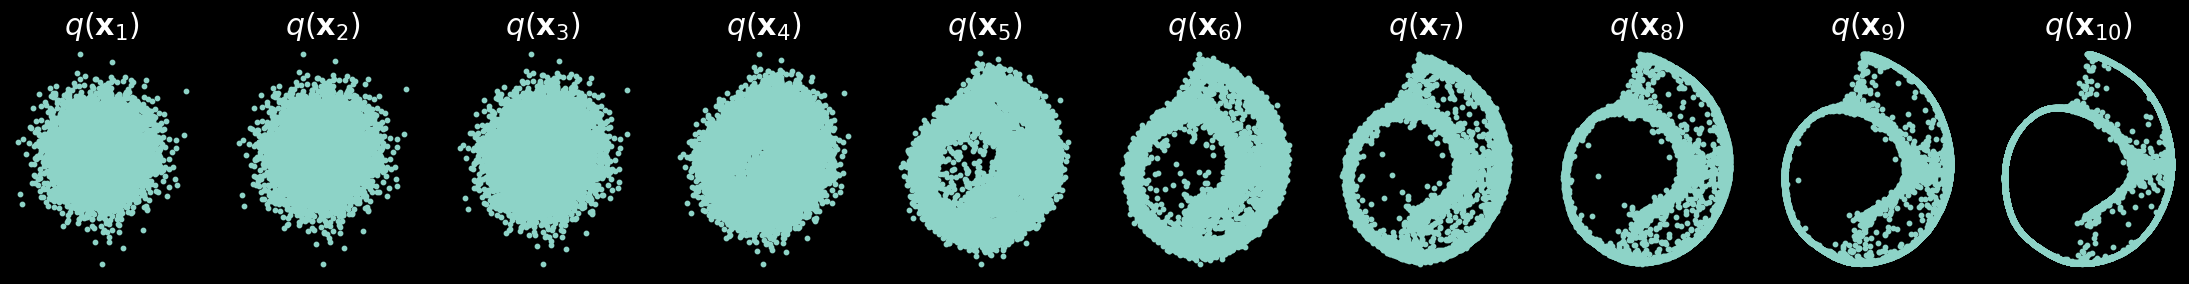

In [26]:
x_seq = EDM_sampling(model, 111, dataset.shape[0], sigma_max=5., sigma_min = 0.0001)
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(1, 11):
    cur_x = x_seq[i*len(x_seq)//10-1].detach()
    axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10)
    axs[i-1].set_axis_off(); axs[i-1].set_title('$q(\mathbf{x}_{'+str(i)+'})$')
plt.show()

## Bibliography

<a id="ref1"/>

[1] [Ho, J., Jain, A., & Abbeel, P. (2020). _Denoising diffusion probabilistic models_. arXiv preprint arXiv:2006.11239.](https://arxiv.org/pdf/2006.11239)

<a id="ref2"/>

[2] [Sohl-Dickstein, J., Weiss, E. A., Maheswaranathan, N., & Ganguli, S. (2015). Deep unsupervised learning using nonequilibrium thermodynamics. arXiv preprint arXiv:1503.03585.](https://arxiv.org/pdf/1503.03585)

<a id="ref3"/>

[3] [Vincent, P. (2011). A connection between score matching and denoising autoencoders. Neural computation, 23(7), 1661-1674.](http://www-labs.iro.umontreal.ca/~vincentp/Publications/smdae_techreport_1358.pdf)

<a id="ref4"/>

[4] [Song, J., Meng, C., & Ermon, S. (2020). Denoising Diffusion Implicit Models. arXiv preprint arXiv:2010.02502.](https://arxiv.org/pdf/2010.02502.pdf)

<a id="ref5"/>

[5] [Chen, N., Zhang, Y., Zen, H., Weiss, R. J., Norouzi, M., & Chan, W. (2020). _WaveGrad: Estimating gradients for waveform generation_. arXiv preprint arXiv:2009.00713.](https://arxiv.org/pdf/2009.00713)

<a id="ref6"/>

[6] [Hyvärinen, A. (2005). Estimation of non-normalized statistical models by score matching. Journal of Machine Learning Research, 6(Apr), 695-709.](http://jmlr.org/papers/volume6/hyvarinen05a/old.pdf)

<a id="ref7"/>

[7] [Song, Y., Garg, S., Shi, J., & Ermon, S. (2020, August). Sliced score matching: A scalable approach to density and score estimation. In Uncertainty in Artificial Intelligence (pp. 574-584). PMLR.](https://arxiv.org/pdf/1905.07088.pdf)

<a id="ref8"/>

[8] [Song, Y., & Ermon, S. (2019). Generative modeling by estimating gradients of the data distribution. In Advances in Neural Information Processing Systems (pp. 11918-11930).](https://arxiv.org/pdf/1907.05600.pdf)

<a id="ref9"/>

[9] [Karras, T., Aittala, M., Aila, T., & Laine, S. (2022). Elucidating the design space of diffusion-based generative models. Advances in neural information processing systems, 35, 26565-26577](https://arxiv.org/pdf/2206.00364)

### Inspiration and sources

https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/score_matching.ipynb
https://github.com/ermongroup/sliced_score_matching